In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
#from plotting import annotate_corr
#from matplotlib.lines import Line2D
#from functools import partial
#from scipy import stats

sns.set(style='ticks', context='paper',
        rc={'font.size': 6, 
            'axes.titlesize': 7,
            'axes.labelsize': 7,
            'axes.labelpad': 2,
            'xtick.labelsize': 5,
            'ytick.labelsize': 5,
            'legend.title_fontsize' : 5.5,
            'legend.fontsize' : 5.5,
            'legend.markerscale': 0.5,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.linewidth': 0.4,
            'xtick.major.width': 0.4,
            'ytick.major.width': 0.4,
            'xtick.major.size': 2.5,
            'ytick.major.size': 2.5,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'ytick.minor.width': 0.2,
            'figure.constrained_layout.use': True,
            'figure.dpi': 200})

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}


#data = pd.merge(pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'), pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),on=id_columns)


In [ ]:
#specified weights plus pooling
# - not interesting after channels=features

#SVD
# - not for main result

#Z Score eigenspectrum

#Num filters?
# - have num filters with specified eigenspectrum...





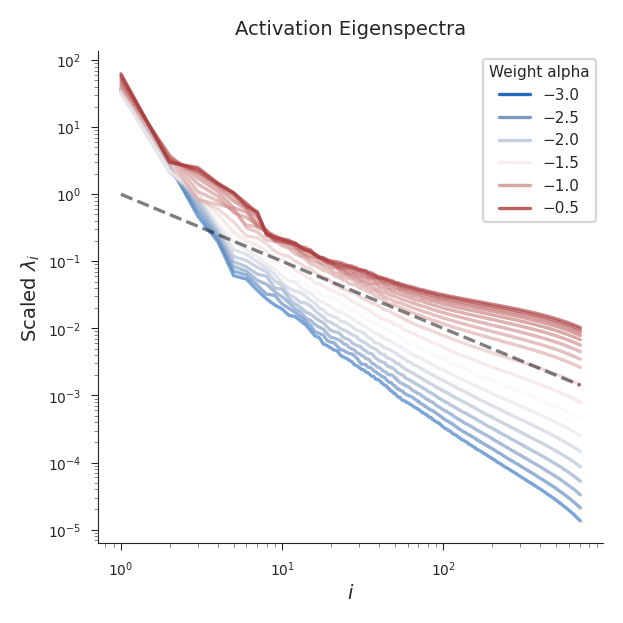

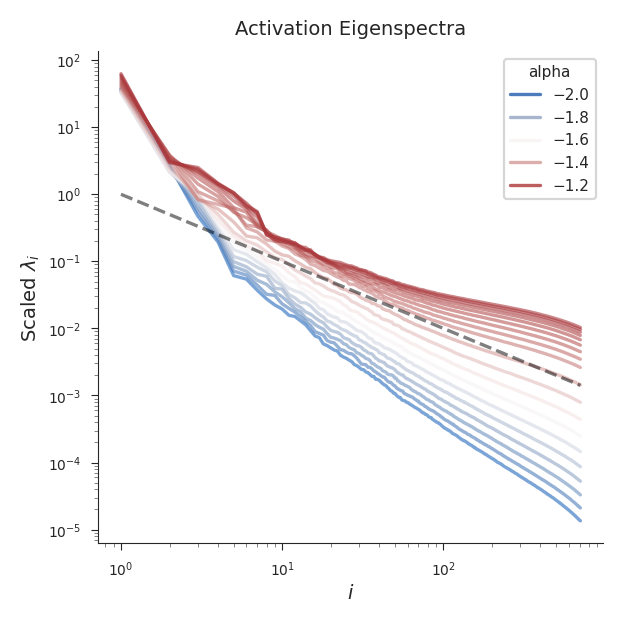

ED p 0.0


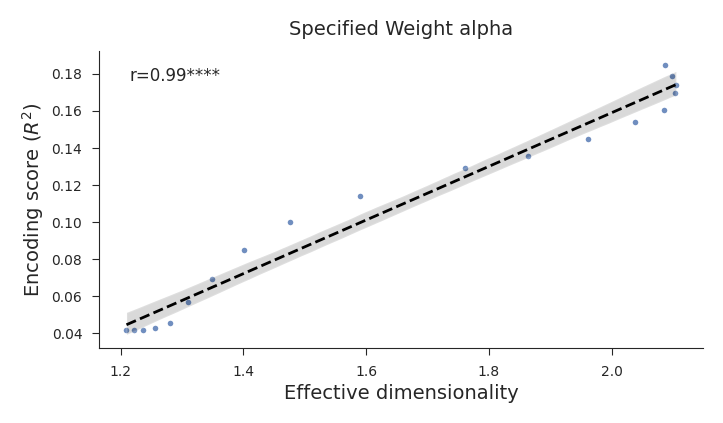

alpha p 0.0


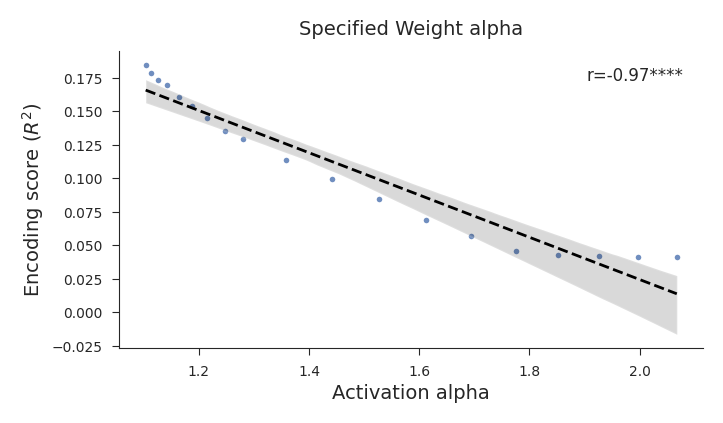

kernel size p 0.0


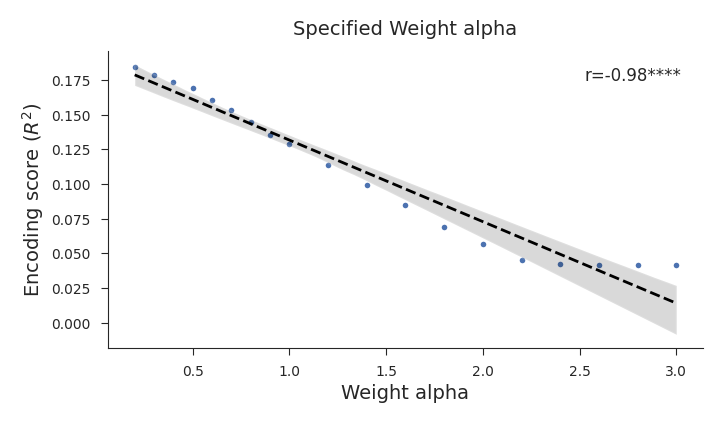

kernel size p 0.0


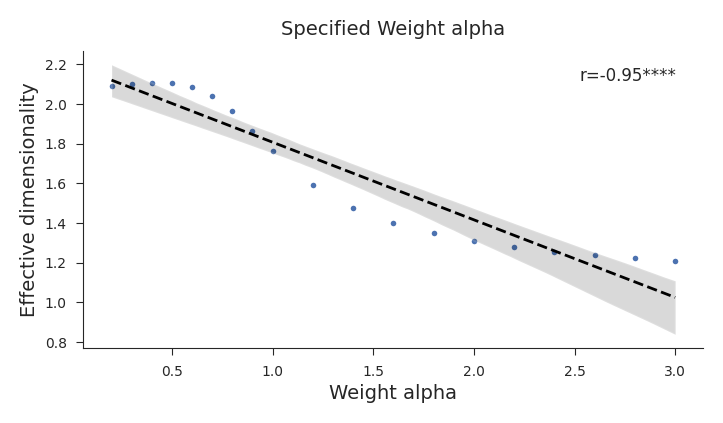

kernel size p 0.0


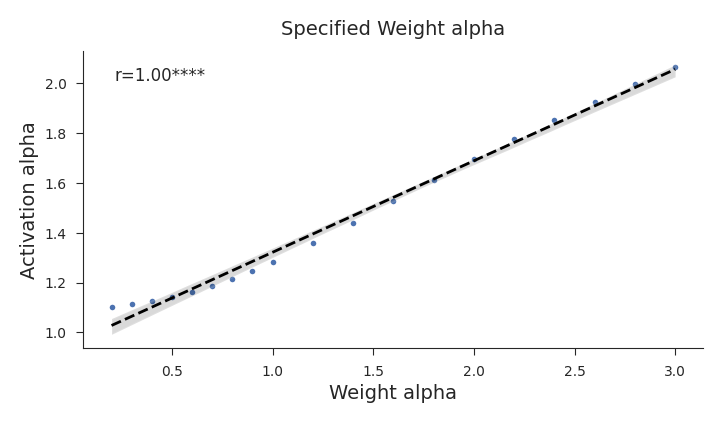

In [6]:
#Specified Weight Eigenspectrum:

metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANalphas|dataset:imagenet|pooling:max|grayscale:False.csv')
spectra = pd.read_csv(f'../../../results_marcc/capstone/eigspectra_ANalphas|dataset:imagenet|pooling:max|grayscale:False.csv')
data = pd.merge(metrics, spectra, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
data['weight_alpha'] = data['kind'].str.split('_').str[1].astype(float)


# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = round(np.log10(data['effective dimensionality']), 2)

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='weight_alpha',
             units='id', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Activation Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Weight alpha')
plt.show()


#eigenspectra hue = alpha
data['neg_alpha'] = data['alpha'].astype(float).mul(-1)

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='neg_alpha',
             units='id', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Activation Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'alpha')
plt.show()


#_Enoding score_

encoding = pd.read_csv(f'../../../results_marcc/capstone/encoding_ANalphas|seed:0|pooling:layerPCA|nPCs:1000|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
metrics.loc[:, 'source'] = metrics['source'].replace({'pcs_NA': 'pcs_1000'})
data = pd.merge(encoding, metrics, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['weight_alpha'] = data['kind'].str.split('_').str[1].astype(float).mul(-1)

#___no logs___
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])
print('ED p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title='Specified Weight alpha')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0, 10)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#alpha

#___no logs___
r, p = sp.stats.pearsonr(data['alpha'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''
    
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Activation alpha', ylabel=r'Encoding score ($R^2$)', title='Specified Weight alpha')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#_Weight alpha & Score_

r, p = sp.stats.pearsonr(data['weight_alpha'], data['score'])
print('kernel size p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='weight_alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Weight alpha', ylabel=r'Encoding score ($R^2$)', title='Specified Weight alpha')#, xscale='log')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()

#_Kernel size & ED_
r, p = sp.stats.pearsonr(data['weight_alpha'], data['effective dimensionality'])
print('kernel size p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='weight_alpha', y='effective dimensionality', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Weight alpha', ylabel=r'Effective dimensionality', title='Specified Weight alpha')#, xscale='log')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()

#_Kernel size & alpha_
r, p = sp.stats.pearsonr(data['weight_alpha'], data['alpha'])
print('kernel size p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='weight_alpha', y='alpha', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Weight alpha', ylabel=r'Activation alpha', title='Specified Weight alpha')#, xscale='log')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()

ED p 0.0
logED 1.0 0.0


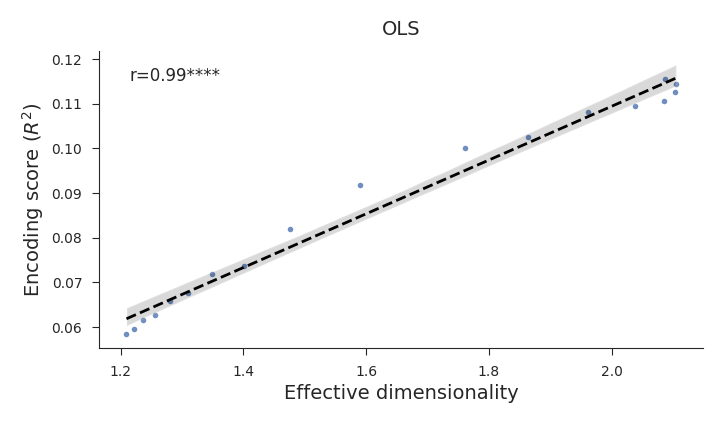

alpha p 0.0
logalpha -0.98 0.0


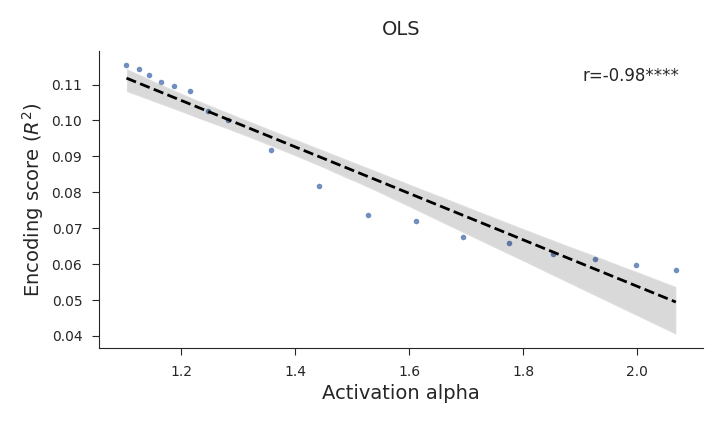

kernel size p 0.0


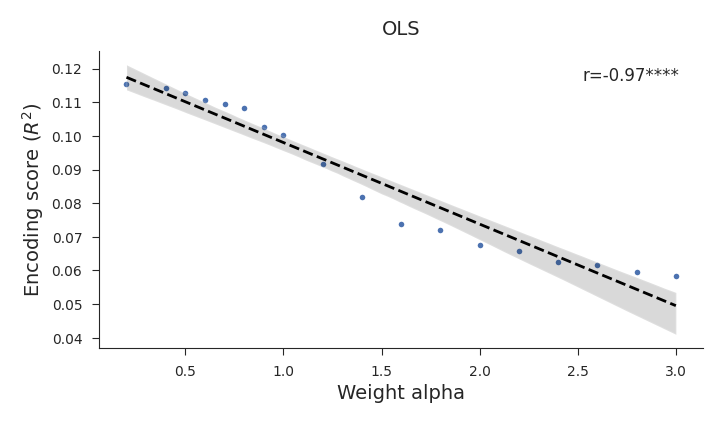

ED p 0.0
logED 1.0 0.0


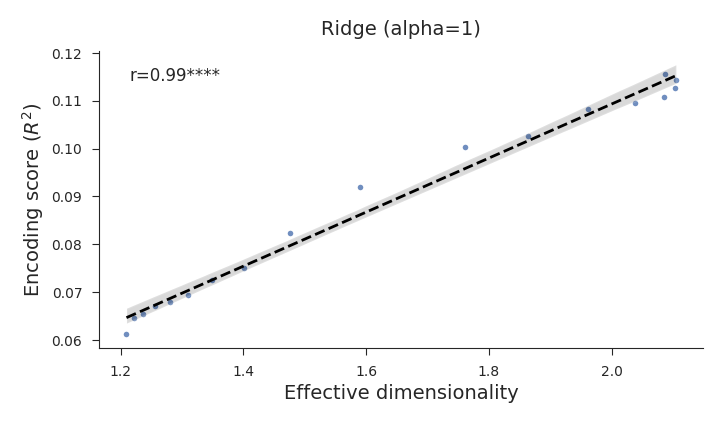

alpha p 0.0
logalpha -0.98 0.0


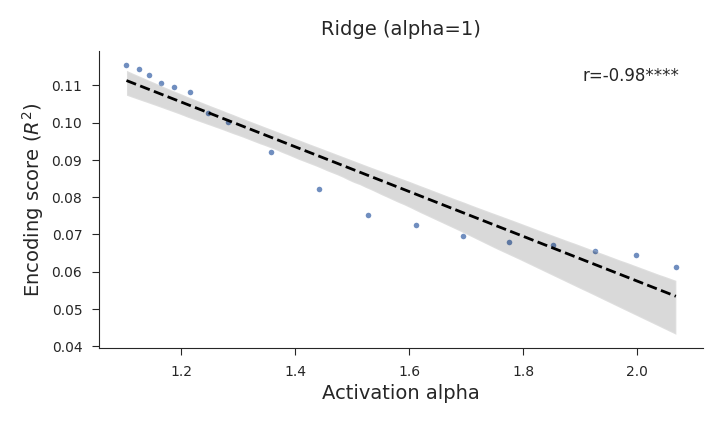

kernel size p 0.0


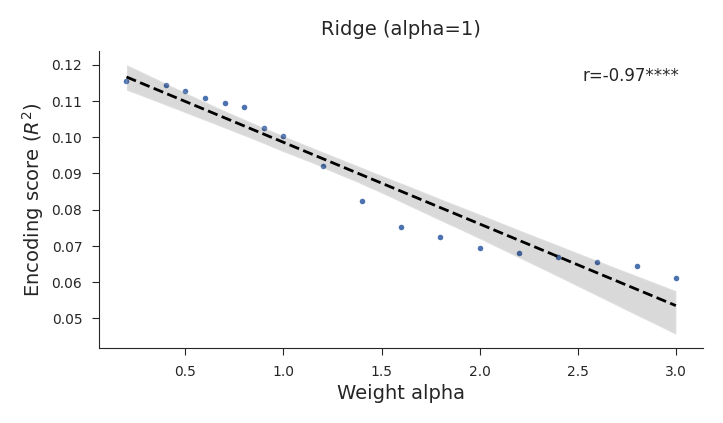

ED p 0.0
logED 0.85 0.0


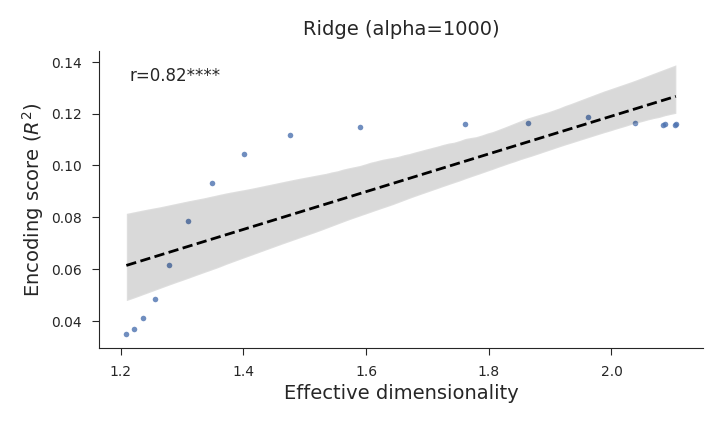

alpha p 0.0
logalpha -0.94 0.0


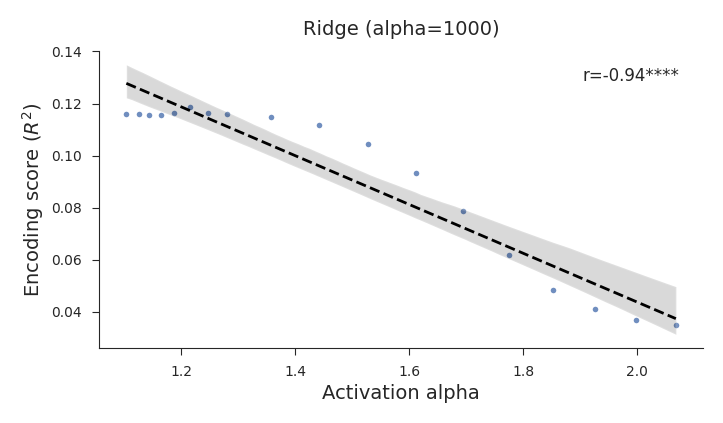

kernel size p 0.0


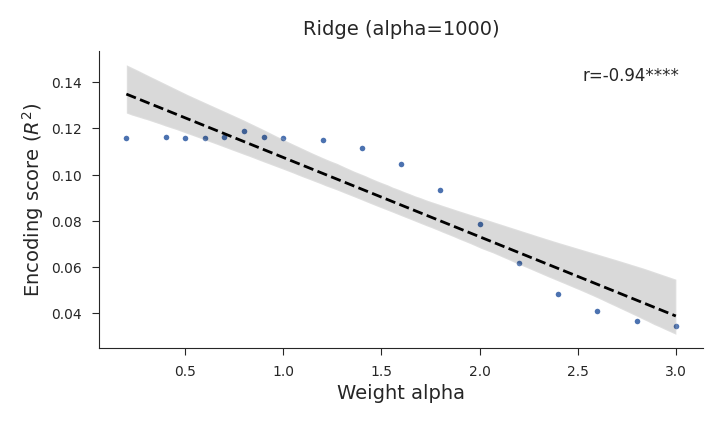

In [6]:
# Regression analysis
# - same eigenspectra as specified weights
# - activation and weight alpha is very correlated, therefore activation/weight alpha v. score = same


#PLS above

#OLS:
metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANalphas|dataset:imagenet|pooling:max|grayscale:False.csv')
metrics.drop(metrics[ metrics['kind'] == 'a_-0.3'].index, inplace=True)
metrics.loc[:, 'task'] = metrics['task'].replace({'Eig_seed=0': 'Eig-OLS'})
#metrics.reset_index()

encoding = pd.read_csv(f'../../../results_marcc/capstone/encoding_Eig-OLS|benchmark:dicarlo.MajajHong2015.IT.public-lin|pooling:none.csv')
encoding = encoding[ encoding['layer'] == 'c2']
encoding.drop([encoding.index[1], encoding.index[2]], inplace=True)
encoding.loc[:, 'source'] = encoding['source'].replace({'PyTorch': 'pcs_NA'})

weight_alpha = encoding['task'].str.split('-').str[-1] #positive
encoding['kind'] = 'a_-' + weight_alpha #add negative
reg = encoding['task'].str.split('-').str[1]
method = encoding['task'].str.split('-').str[0]
encoding['task'] = method.str.cat(reg, sep='-')
#encoding.reset_index()


data = pd.merge(encoding, metrics, on=id_columns)
data['weight_alpha'] = weight_alpha.astype(float).reset_index(drop=True)


# - ED
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])
print('ED p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

data['log_ed'] = np.log10(data['effective dimensionality'])
rlog, plog = sp.stats.pearsonr(data['log_ed'], data['score'])
print('logED', round(rlog,2), round(plog, 4))

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title='OLS')#, xscale='log')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0, 10)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


# - alpha
r, p = sp.stats.pearsonr(data['alpha'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

data['log_alpha'] = np.log10(data['alpha'])
r, p = sp.stats.pearsonr(data['log_alpha'], data['score'])
print('logalpha', round(r,2), round(p, 4))

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Activation alpha', ylabel=r'Encoding score ($R^2$)', title='OLS')#, xscale='log')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#_Weight alpha & Score_
r, p = sp.stats.pearsonr(data['weight_alpha'], data['score'])
print('kernel size p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='weight_alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Weight alpha', ylabel=r'Encoding score ($R^2$)', title='OLS')#, xscale='log')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#Ridge alpha=1

metrics.loc[:, 'task'] = metrics['task'].replace({'Eig-OLS': 'Eig-Ridge1'})

encoding = pd.read_csv(f'../../../results_marcc/capstone/encoding_Eig-Ridge1|benchmark:dicarlo.MajajHong2015.IT.public-ridge_alpha=1|pooling:none.csv')
encoding = encoding[ encoding['layer'] == 'c2']
encoding.drop([encoding.index[1], encoding.index[2]], inplace=True)
encoding.loc[:, 'source'] = encoding['source'].replace({'PyTorch': 'pcs_NA'})

weight_alpha = encoding['task'].str.split('_').str[-1] #negative
encoding['kind'] = 'a_' + weight_alpha
encoding['task'] = encoding['task'].str.split('_').str[0]


data = pd.merge(encoding, metrics, on=id_columns)
data['weight_alpha'] = weight_alpha.astype(float).mul(-1).reset_index(drop=True) #change to positive


# - ED
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])
print('ED p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

data['log_ed'] = np.log10(data['effective dimensionality'])
rlog, plog = sp.stats.pearsonr(data['log_ed'], data['score'])
print('logED', round(rlog,2), round(plog, 4))

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title='Ridge (alpha=1)')#, xscale='log')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0, 10)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


# - alpha
r, p = sp.stats.pearsonr(data['alpha'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

data['log_alpha'] = np.log10(data['alpha'])
r, p = sp.stats.pearsonr(data['log_alpha'], data['score'])
print('logalpha', round(r,2), round(p, 4))

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Activation alpha', ylabel=r'Encoding score ($R^2$)', title='Ridge (alpha=1)')#, xscale='log')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#_Weight alpha & Score_
r, p = sp.stats.pearsonr(data['weight_alpha'], data['score'])
print('kernel size p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='weight_alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Weight alpha', ylabel=r'Encoding score ($R^2$)', title='Ridge (alpha=1)')#, xscale='log')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#Ridge alpha=1000

metrics.loc[:, 'task'] = metrics['task'].replace({'Eig-Ridge1': 'Eig-Ridge1000'})

encoding = pd.read_csv(f'../../../results_marcc/capstone/encoding_Eig-Ridge1000|benchmark:dicarlo.MajajHong2015.IT.public-ridge_alpha=1000|pooling:none.csv')
encoding = encoding[ encoding['layer'] == 'c2']
encoding.drop([encoding.index[1], encoding.index[2]], inplace=True)
encoding.loc[:, 'source'] = encoding['source'].replace({'PyTorch': 'pcs_NA'})

weight_alpha = encoding['task'].str.split('_').str[-1] #negative
encoding['kind'] = 'a_' + weight_alpha
encoding['task'] = encoding['task'].str.split('_').str[0]


data = pd.merge(encoding, metrics, on=id_columns)
data['weight_alpha'] = weight_alpha.astype(float).mul(-1).reset_index(drop=True) #change to positive


# - ED
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])
print('ED p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

data['log_ed'] = np.log10(data['effective dimensionality'])
rlog, plog = sp.stats.pearsonr(data['log_ed'], data['score'])
print('logED', round(rlog,2), round(plog, 4))

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title='Ridge (alpha=1000)')#, xscale='log')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0, 10)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


# - alpha
r, p = sp.stats.pearsonr(data['alpha'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

data['log_alpha'] = np.log10(data['alpha'])
r, p = sp.stats.pearsonr(data['log_alpha'], data['score'])
print('logalpha', round(r,2), round(p, 4))

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Activation alpha', ylabel=r'Encoding score ($R^2$)', title='Ridge (alpha=1000)')#, xscale='log')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#_Weight alpha & Score_
r, p = sp.stats.pearsonr(data['weight_alpha'], data['score'])
print('kernel size p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='weight_alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Weight alpha', ylabel=r'Encoding score ($R^2$)', title='Ridge (alpha=1000)')#, xscale='log')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()

p:  0.0
p:  0.0
weight alpha p: 0.0
p:  0.7978
p:  0.9828
weight alpha p: 0.9548


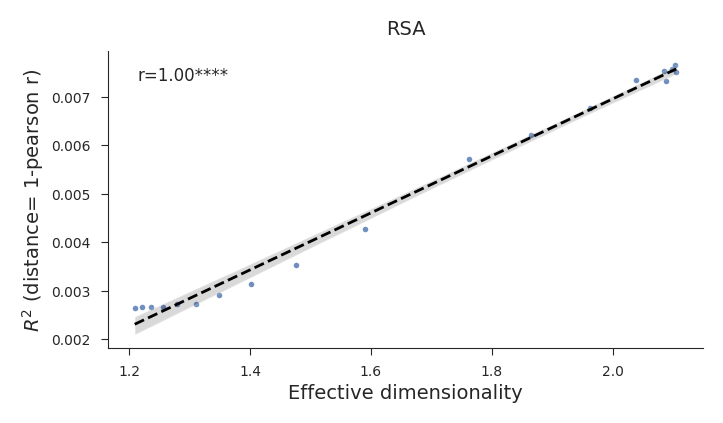

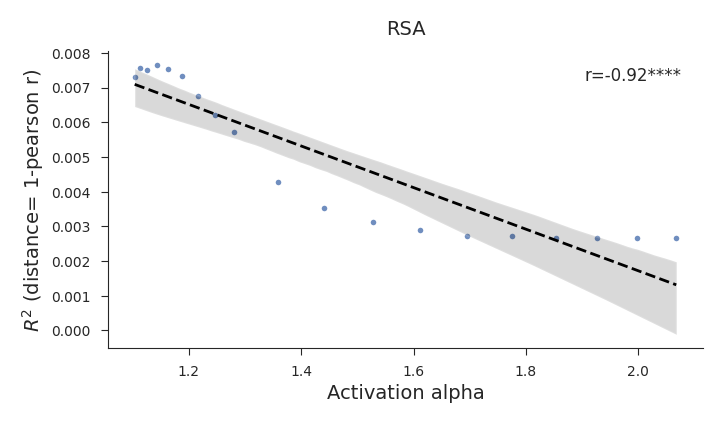

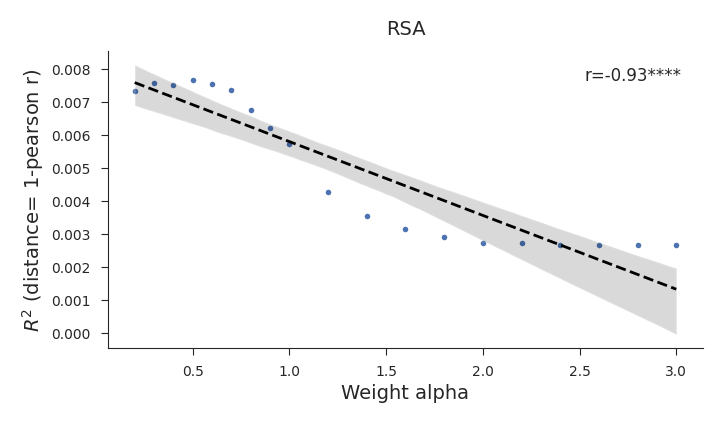

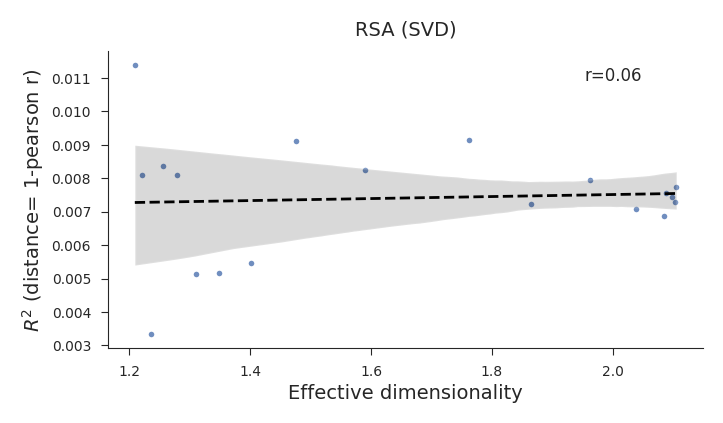

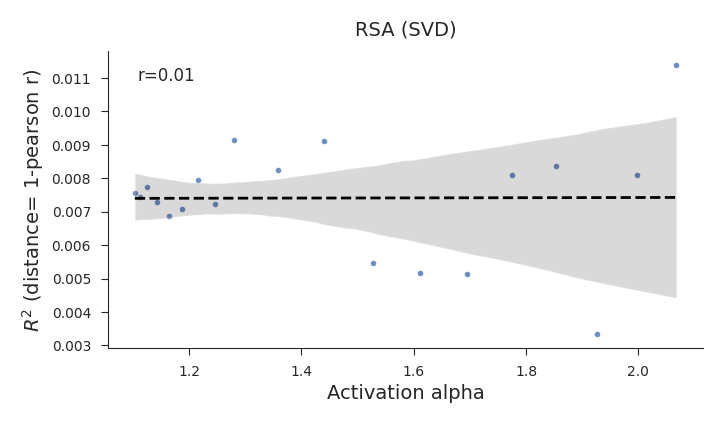

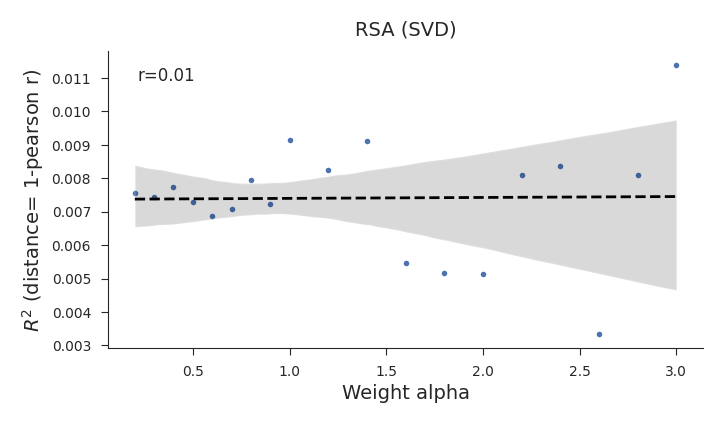

In [11]:
#RSA
# - used Eig-Reg (for RSA and regression analysis)

#method = 'Eig'
methods = ['Eig', 'SVD']
rsa_pooling = ['False']#, 'True']

#encoding score

#for pool in rsa_pooling:
pool = 'False'
for method in methods:

    if method == 'Eig':
        t = 'RSA'
    elif method == 'SVD':
        f_spec = 'ScaledSVD-Reg'
        t = 'RSA (SVD)'
    
    metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANalphas|dataset:imagenet|pooling:max|grayscale:False.csv')
    metrics['task'] = 'Eig-RSA'
    
    encoding = pd.read_csv(f'../../../results_marcc/capstone/rsa_{method}|benchmark:dicarlo.MajajHong2015.IT.public-rsa|pooling:{pool}.csv')
    encoding = encoding[ (encoding['layer']=='c2')].reset_index(drop=True)
    encoding['source'] = metrics['source']
    encoding['kind'] = metrics['kind']
    encoding['task'] = 'Eig-RSA'
    
    data = pd.merge(encoding, metrics, on=id_columns)
    data['id'] = data[id_columns].sum(axis='columns')
    data['weight_alpha']= metrics['kind'].str.split('_').str[-1].astype(float).mul(-1).reset_index(drop=True)
    

    predictors = ['effective dimensionality', 'alpha']
    for pred in predictors:
        r, p = sp.stats.pearsonr(data[pred], data['score'])
        print('p: ', round(p, 4))
        if p < 0.0001:
            sig = '****'
        elif p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        elif p < 0.05:
            sig = '*'
        else:
            sig = ''

        fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
        sns.regplot(data=data, x=pred, y='score', 
                    logx=False,
                    scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                    line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                    ax=ax)
        if pred == 'effective dimensionality':
            xl = 'Effective dimensionality'
            if method == 'Eig':
                r_xloc = 0.05
            else:
                r_xloc = 0.8
        if pred == 'alpha':
            xl = 'Activation alpha'
            if method == 'Eig':
                r_xloc = 0.8
            else:
                r_xloc = 0.05
        ax.set(xlabel=f'{xl}', ylabel=r'$R^2$ (distance= 1-pearson r)', title=t)
        ax.text(r_xloc, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
        #ax.set_ylim(bottom=0, top=0.65)
        #ax.set_xlim(0.8, 270)
        
        
    r, p = sp.stats.pearsonr(data['weight_alpha'], data['score'])
    print('weight alpha p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data, x='weight_alpha', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Weight alpha', ylabel=r'$R^2$ (distance= 1-pearson r)', title=t)#, xscale='log')
    if method == 'Eig':
        r_xloc = 0.8
    else:
        r_xloc = 0.05
    ax.text(r_xloc, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)

plt.show()






n_PCs p: 0.0352
n_PCs p: 0.0243
n_PCs p: 0.3085
n_PCs p: 0.3687


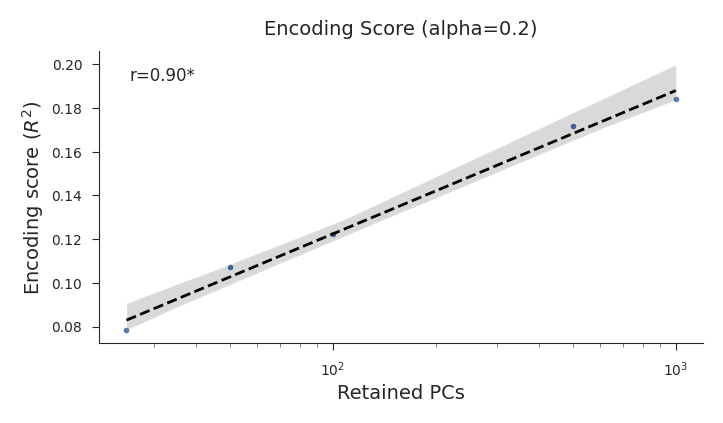

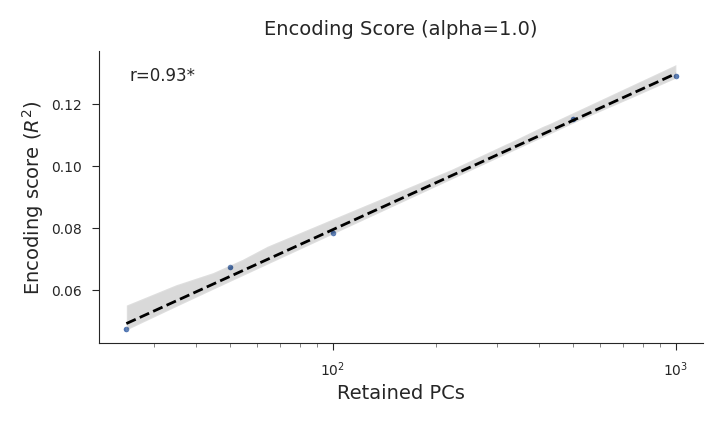

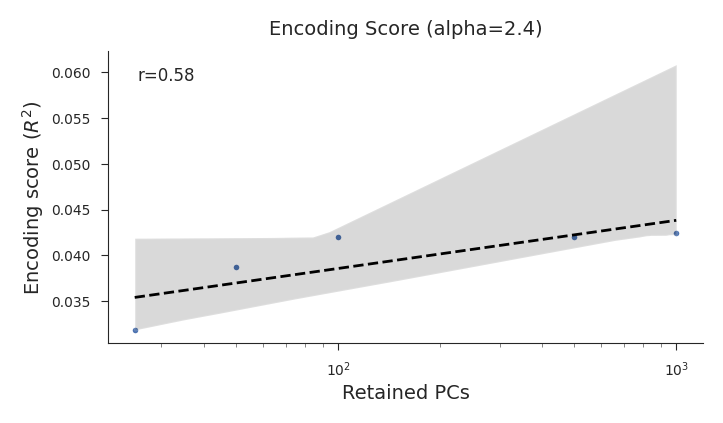

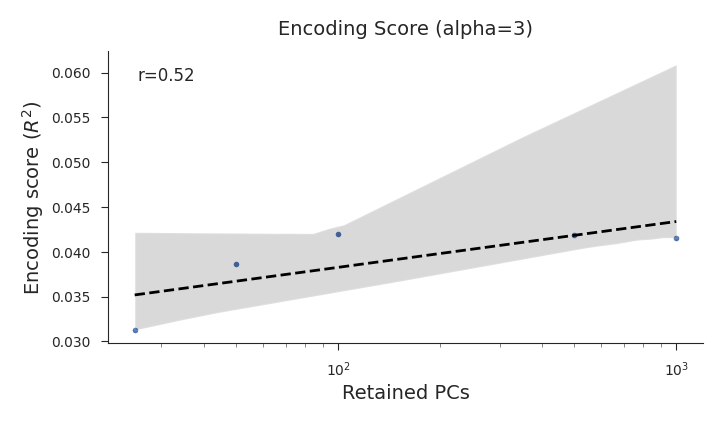

n_PCs p: 0.1685
n_PCs p: 0.3473
n_PCs p: 0.7637
n_PCs p: 0.9167


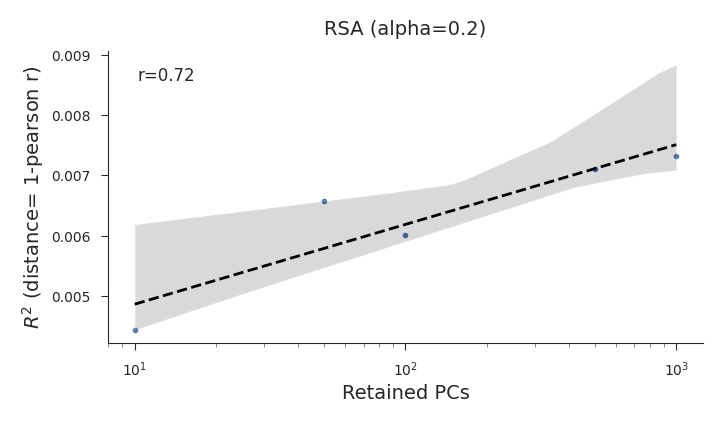

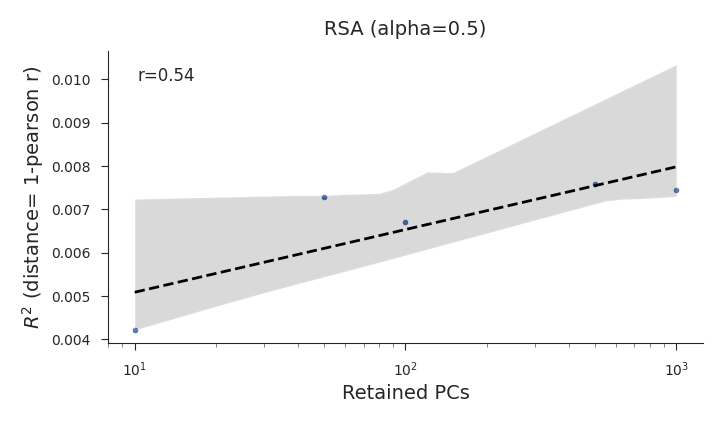

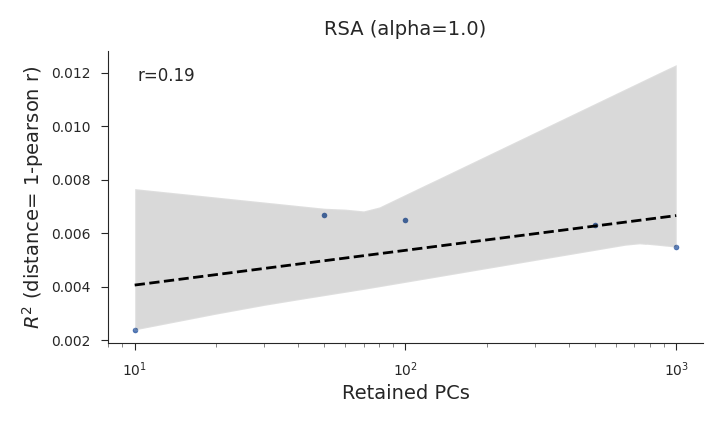

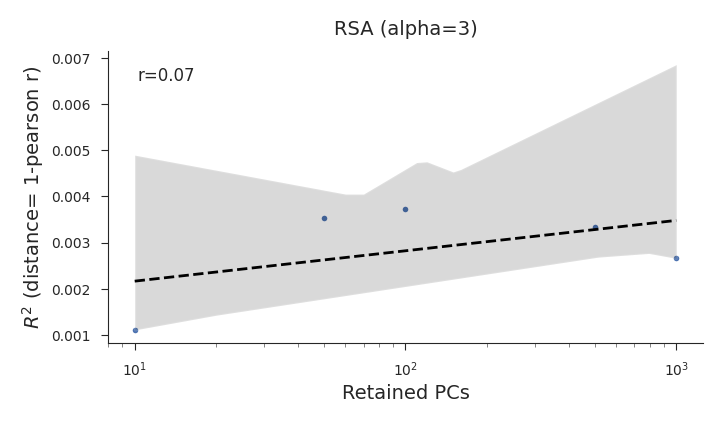

In [14]:
#nPCs
#*log scale?

    
#metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANalphas|dataset:imagenet|pooling:max|grayscale:False.csv')
#metrics['task'] = 'Eig-RSA'

#__Encoding score__

data = pd.read_csv(f'../../../results_marcc/nPCs/nPCs_seed/encoding_Eig|all_nPCs|seed:0|pooling:layerPCA|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
data['n_PCs']= data['source'].str.split('_').str[-1].astype(float)
#data['weight_alpha']= metrics['kind'].str.split('_').str[-1].astype(float).mul(-1)
#data['id'] = data[id_columns].sum(axis='columns')

alphas = [0.2, 1.0, 2.4, 3]
for a in alphas:
    data_plot = data[ (data['kind'] == f'a_-{a}')]
    
    r, p = sp.stats.pearsonr(data_plot['n_PCs'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='n_PCs', y='score', 
                logx=True,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Retained PCs', ylabel=r'Encoding score ($R^2$)', title=f'Encoding Score (alpha={a})', xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
    
plt.show()


#__RSA__

data = pd.read_csv(f'../../../results_marcc/nPCs/nPCs_seed/rsa_Eig|all_nPCs|seed:0|pooling:layerPCA|benchmark:dicarlo.MajajHong2015.IT.public-rsa.csv')
data['n_PCs']= data['source'].str.split('_').str[-1].astype(float)

alphas = [0.2, 0.5, 1.0, 3]
for a in alphas:
    data_plot = data[ (data['kind'] == f'a_-{a}')]
    
    r, p = sp.stats.pearsonr(data_plot['n_PCs'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='n_PCs', y='score', 
                logx=True,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Retained PCs', ylabel=r'$R^2$ (distance= 1-pearson r)', title=f'RSA (alpha={a})', xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
plt.show()



n_PCs p: 0.0
n_PCs p: 0.0
n_PCs p: 0.0
n_PCs p: 0.0


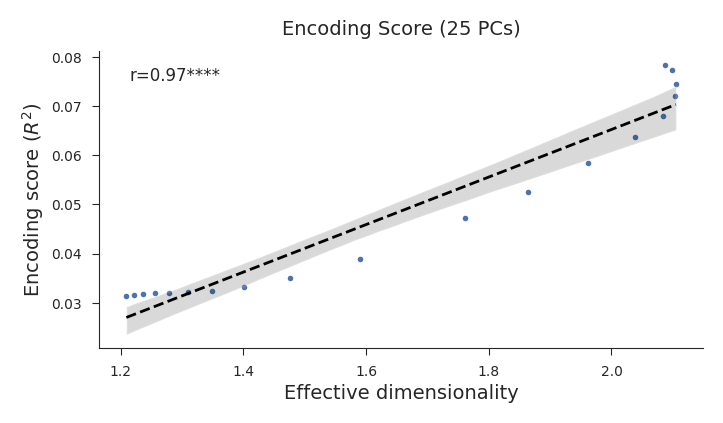

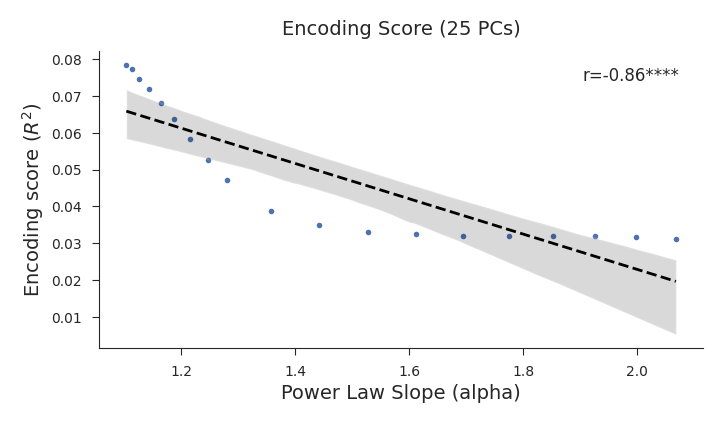

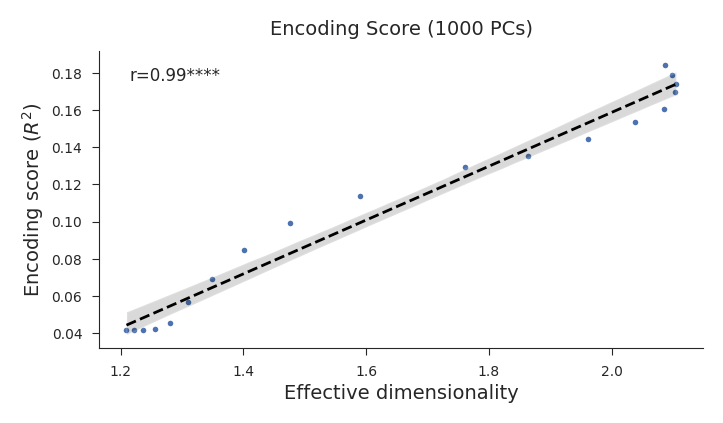

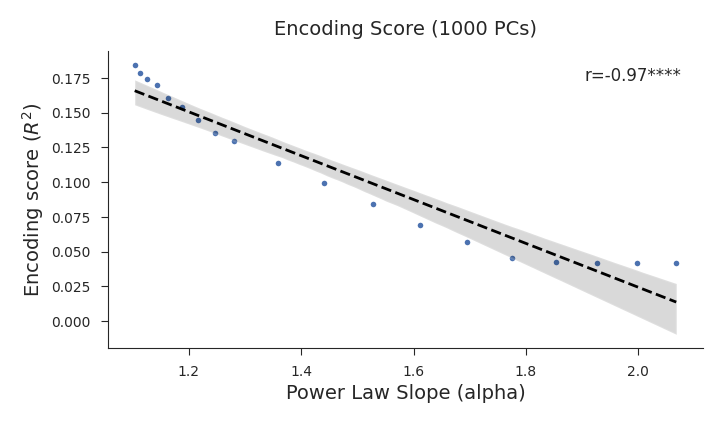

n_PCs p: 0.0
n_PCs p: 0.0
n_PCs p: 0.0
n_PCs p: 0.0


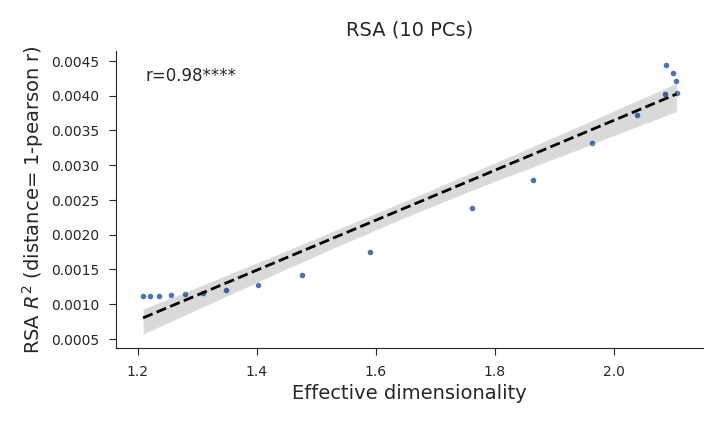

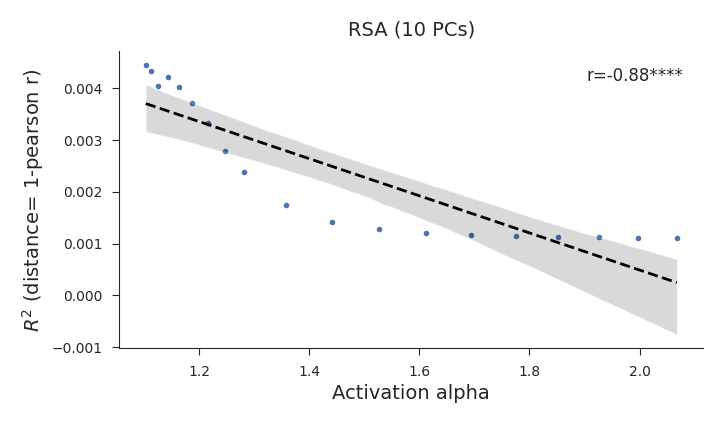

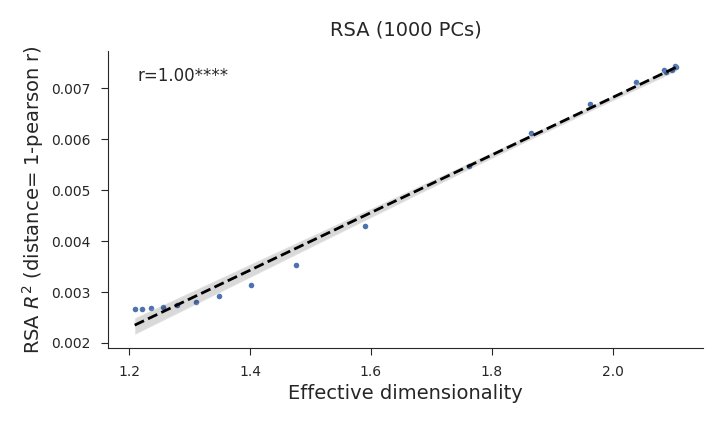

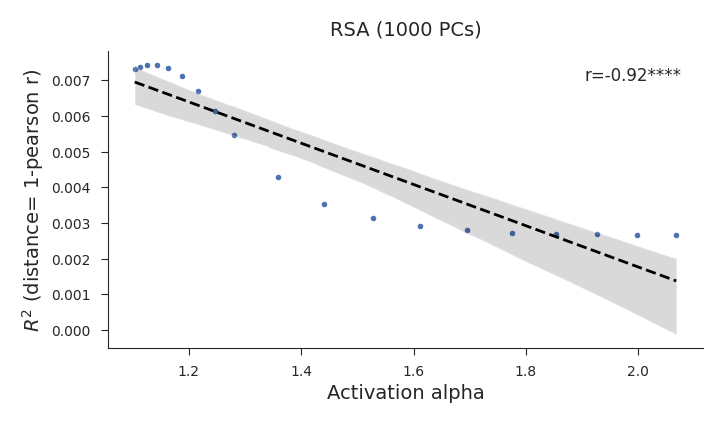

In [17]:
#nPCs - ED vs Score

#***as nPCs increases fit between alpha and score goes up
# - log scale?

    
metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANalphas|dataset:imagenet|pooling:max|grayscale:False.csv')
encoding = pd.read_csv(f'../../../results_marcc/nPCs/nPCs_seed/encoding_Eig|all_nPCs|seed:0|pooling:layerPCA|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')

#n_PCs = encoding['source'].str.split('_').str[-1].unique().astype(int)
n_PCs = [25, 1000]

#data = pd.merge(encoding, metrics, on=id_columns)
#data['n_PCs']= data['source'].str.split('_').str[-1].astype(float)

#__Encoding score__

for n in n_PCs:
    encoding_plot = encoding[ (encoding['source'] == f'pcs_{n}')]
    metrics['source'] = f'pcs_{n}'
    
    data_plot = pd.merge(encoding_plot, metrics, on=id_columns)
    data_plot['n_PCs'] = n
    
#ed
    r, p = sp.stats.pearsonr(data_plot['effective dimensionality'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='effective dimensionality', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title=f'Encoding Score ({n} PCs)')#, xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
    
#alpha
    r, p = sp.stats.pearsonr(data_plot['alpha'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='alpha', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'Encoding score ($R^2$)', title=f'Encoding Score ({n} PCs)')#, xscale='log')
    ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
    
plt.show()


#__RSA__

encoding = pd.read_csv(f'../../../results_marcc/nPCs/nPCs_seed/rsa_Eig|all_nPCs|seed:0|pooling:layerPCA|benchmark:dicarlo.MajajHong2015.IT.public-rsa.csv')

#n_PCs = encoding['source'].str.split('_').str[-1].unique().astype(int)
n_PCs = [10, 1000]

for n in n_PCs:
    encoding_plot = encoding[ (encoding['source'] == f'pcs_{n}')]
    metrics['source'] = f'pcs_{n}'
    
    data_plot = pd.merge(encoding_plot, metrics, on=id_columns)
    data_plot['n_PCs'] = n

#ed
    r, p = sp.stats.pearsonr(data_plot['effective dimensionality'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='effective dimensionality', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Effective dimensionality', ylabel=r'RSA $R^2$ (distance= 1-pearson r)', title=f'RSA ({n} PCs)')#, xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
    
#alpha
    r, p = sp.stats.pearsonr(data_plot['alpha'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='alpha', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Activation alpha', ylabel=r'$R^2$ (distance= 1-pearson r)', title=f'RSA ({n} PCs)')#, xscale='log')
    ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
plt.show()



In [ ]:
data = pd.read_csv(f'../../../results_marcc/capstone/nPCs/pooling/encoding_EigMP_allPCs|seed:0|pooling:PCA_maxpool|nPCs:all|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
data['n_PCs']= data['source'].str.split('_').str[-1].astype(float)
#data['weight_alpha']= metrics['kind'].str.split('_').str[-1].astype(float).mul(-1)
#data['id'] = data[id_columns].sum(axis='columns')

alphas = [1.2, 1.4, 1.6, 1.8, 2, 3] #right at 2 gets bad
for a in alphas:
    data_plot = data[ (data['kind'] == f'a_-{a}')]
    
    r, p = sp.stats.pearsonr(data_plot['n_PCs'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='n_PCs', y='score', 
                logx=True,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='n PCs', ylabel=r'Encoding score ($R^2$)', title=f'Encoding Score (alpha={a})', xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
plt.show()


n_PCs p: 0.0363
n_PCs p: 0.0164
n_PCs p: 0.0317
n_PCs p: 0.4963
n_PCs p: 0.1764


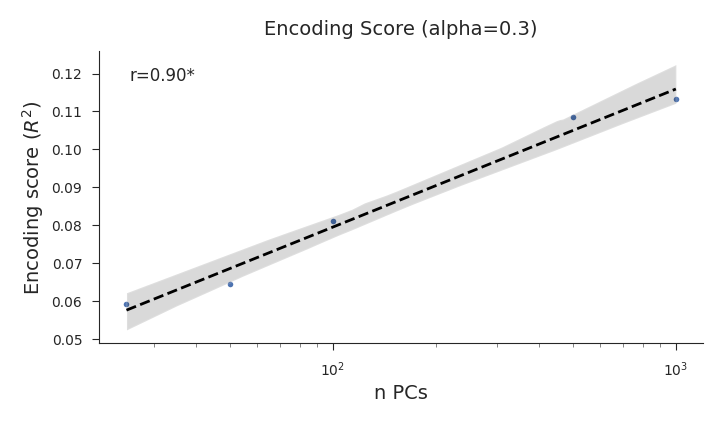

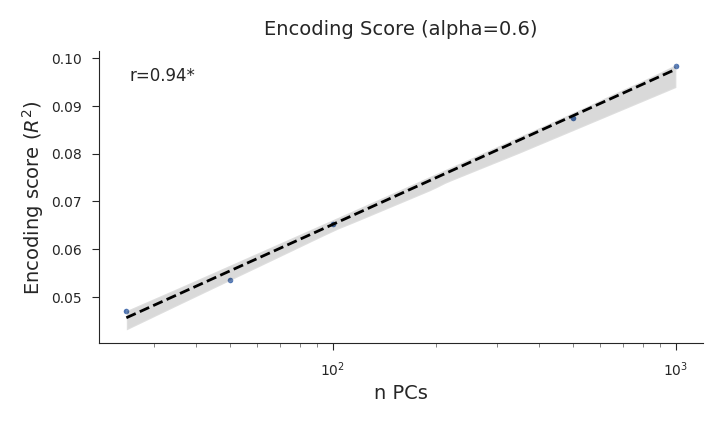

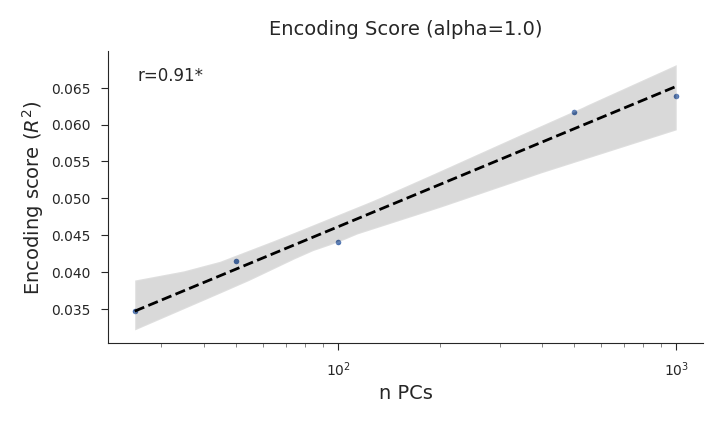

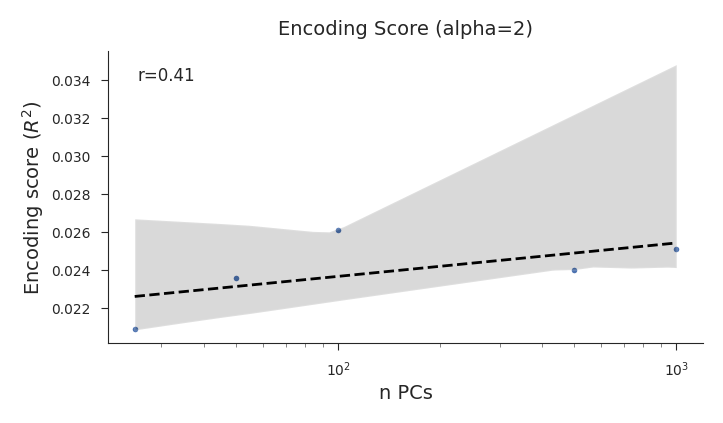

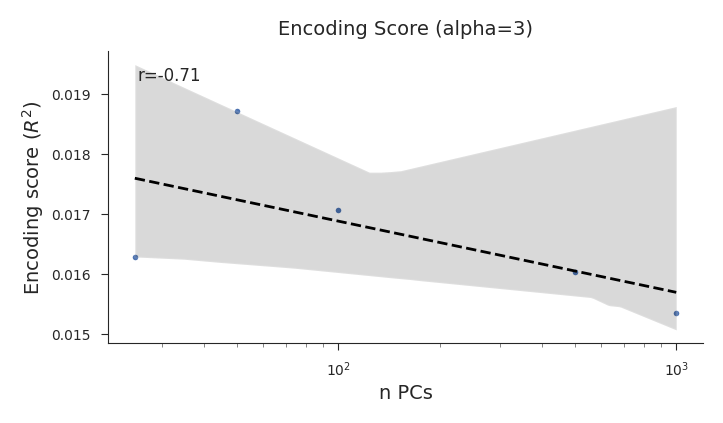

n_PCs p: 0.018
n_PCs p: 0.0087
n_PCs p: 0.1061
n_PCs p: 0.4278
n_PCs p: 0.4743


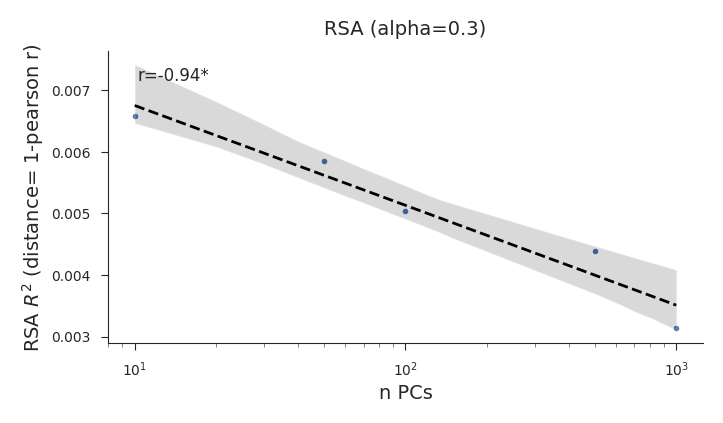

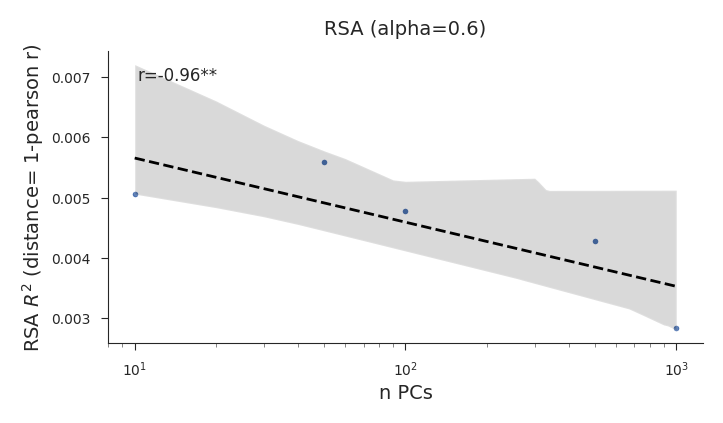

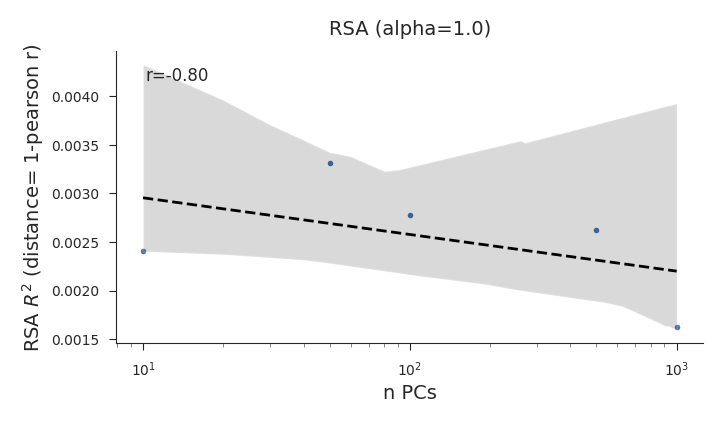

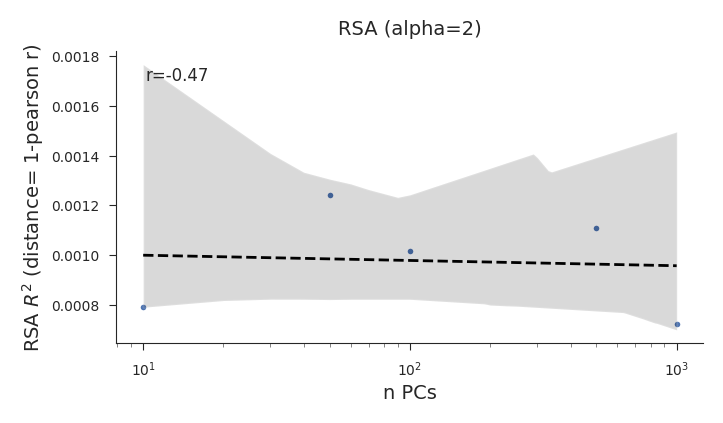

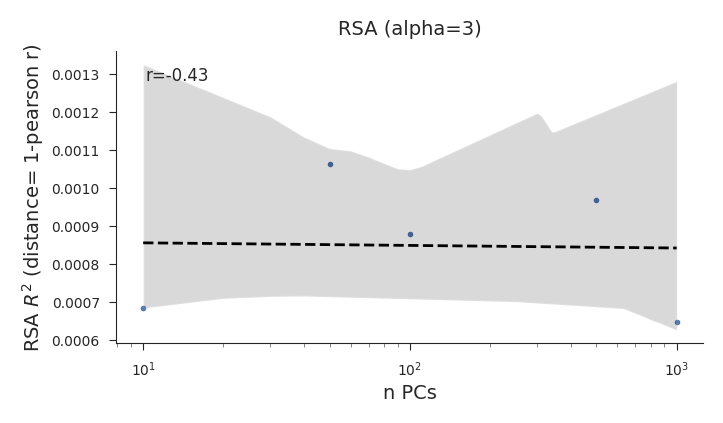

In [4]:
#max pooling then PCA (for scores & RSA.. and RDMs/umaps/)

#__Encoding score__

data = pd.read_csv(f'../../../results_marcc/capstone/nPCs/pooling/encoding_EigMP_allPCs|seed:0|pooling:PCA_maxpool|nPCs:all|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
data['n_PCs']= data['source'].str.split('_').str[-1].astype(float)
#data['weight_alpha']= metrics['kind'].str.split('_').str[-1].astype(float).mul(-1)
#data['id'] = data[id_columns].sum(axis='columns')

alphas = [0.3, 0.6, 1.0, 2, 3] #right at 2 gets bad
for a in alphas:
    data_plot = data[ (data['kind'] == f'a_-{a}')]
    
    r, p = sp.stats.pearsonr(data_plot['n_PCs'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='n_PCs', y='score', 
                logx=True,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='n PCs', ylabel=r'Encoding score ($R^2$)', title=f'Encoding Score (alpha={a})', xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
plt.show()


#__RSA__

data = pd.read_csv(f'../../../results_marcc/capstone/nPCs/pooling/rsa_EigMP_allPCs|seed:0|pooling:PCA_maxpool|nPCs:all|benchmark:dicarlo.MajajHong2015.IT.public-rsa.csv')
data['n_PCs']= data['source'].str.split('_').str[-1].astype(float)

alphas = [0.3, 0.6, 1.0, 2, 3]
for a in alphas:
    data_plot = data[ (data['kind'] == f'a_-{a}')]
    
    r, p = sp.stats.pearsonr(data_plot['n_PCs'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='n_PCs', y='score', 
                logx=True,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='n PCs', ylabel=r'RSA $R^2$ (distance= 1-pearson r)', title=f'RSA (alpha={a})', xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
plt.show()




n_PCs p: 0.0
n_PCs p: 0.0
n_PCs p: 0.0
n_PCs p: 0.0


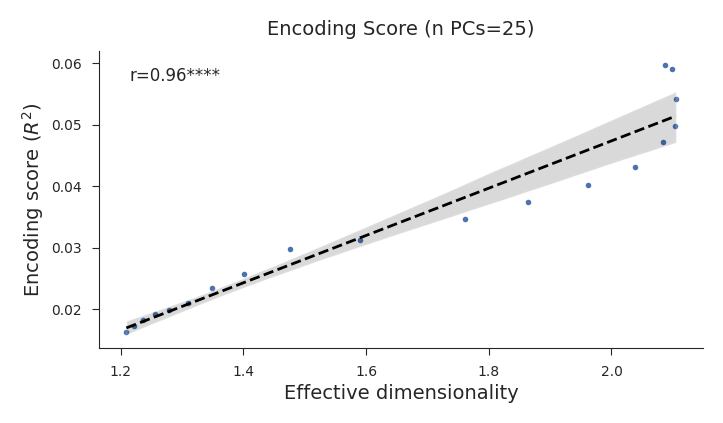

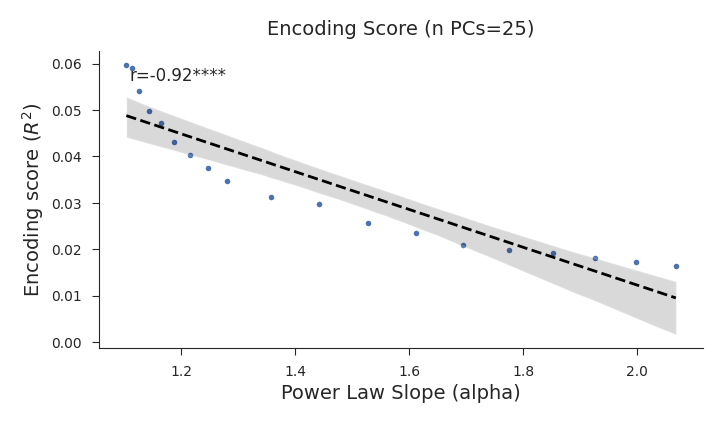

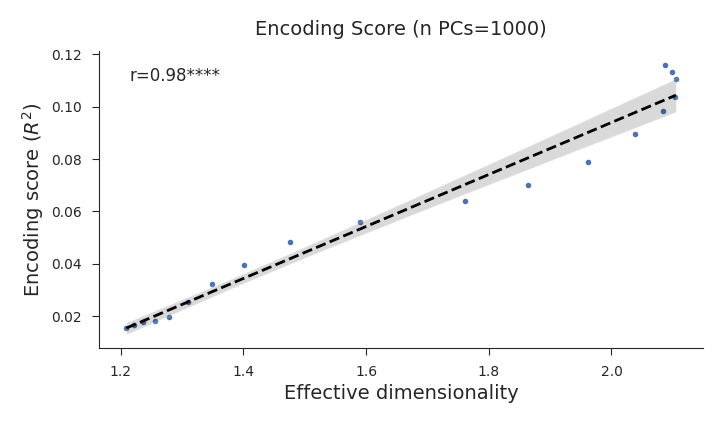

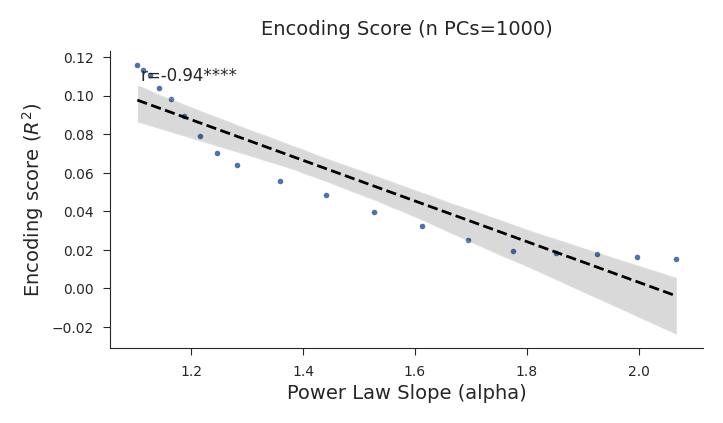

n_PCs p: 0.0
n_PCs p: 0.0
n_PCs p: 0.0
n_PCs p: 0.0


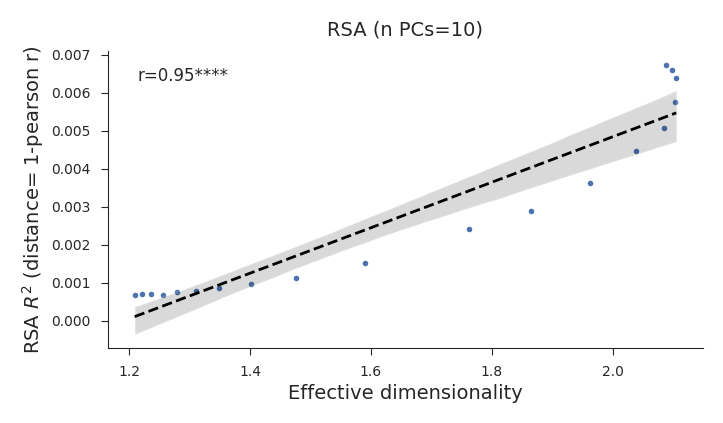

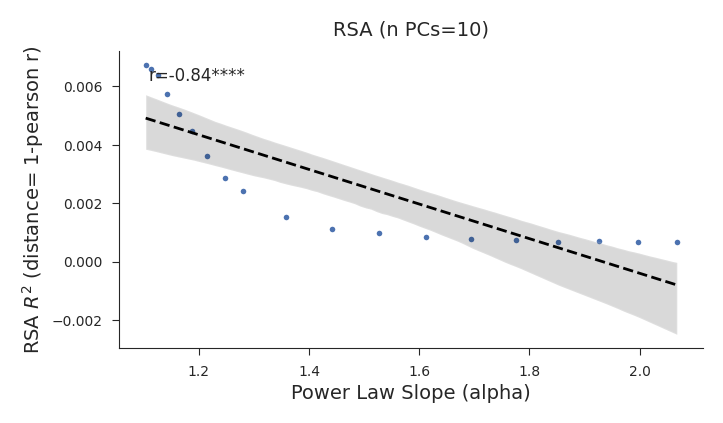

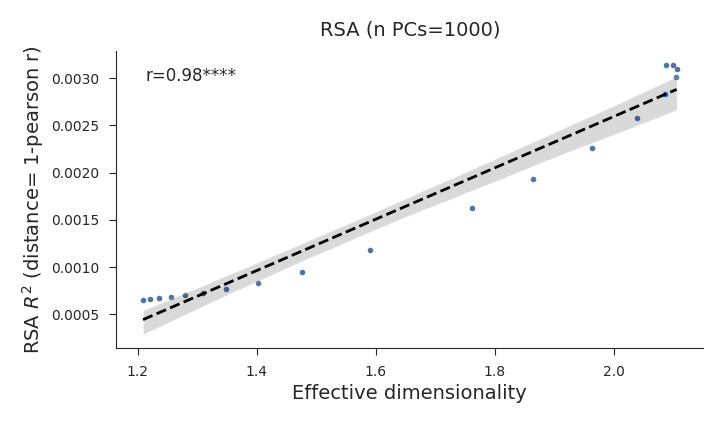

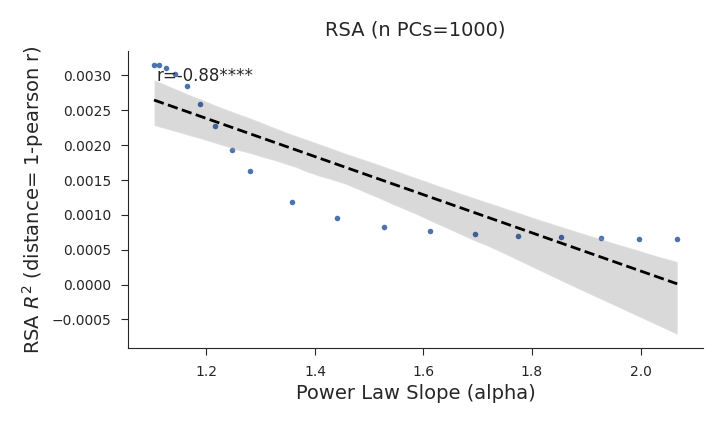

In [25]:
#max pool PCs and ED/alpha

    
metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANalphas|dataset:imagenet|pooling:max|grayscale:False.csv')
encoding = pd.read_csv(f'../../../results_marcc/capstone/nPCs/pooling/encoding_EigMP_allPCs|seed:0|pooling:PCA_maxpool|nPCs:all|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')

#n_PCs = encoding['source'].str.split('_').str[-1].unique().astype(int)
n_PCs = [25, 1000]


#__Encoding score__

for n in n_PCs:
    encoding_plot = encoding[ (encoding['source'] == f'pcs_{n}')]
    metrics['source'] = f'pcs_{n}'
    
    data_plot = pd.merge(encoding_plot, metrics, on=id_columns)
    data_plot['n_PCs'] = n
    
#ed
    r, p = sp.stats.pearsonr(data_plot['effective dimensionality'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='effective dimensionality', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title=f'Encoding Score (n PCs={n})')#, xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
    
#alpha
    r, p = sp.stats.pearsonr(data_plot['alpha'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='alpha', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'Encoding score ($R^2$)', title=f'Encoding Score (n PCs={n})')#, xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
    
plt.show()


#__RSA__

encoding = pd.read_csv(f'../../../results_marcc/capstone/nPCs/pooling/rsa_EigMP_allPCs|seed:0|pooling:PCA_maxpool|nPCs:all|benchmark:dicarlo.MajajHong2015.IT.public-rsa.csv')

#n_PCs = encoding['source'].str.split('_').str[-1].unique().astype(int)
n_PCs = [10, 1000]

for n in n_PCs:
    encoding_plot = encoding[ (encoding['source'] == f'pcs_{n}')]
    metrics['source'] = f'pcs_{n}'
    
    data_plot = pd.merge(encoding_plot, metrics, on=id_columns)
    data_plot['n_PCs'] = n

#ed
    r, p = sp.stats.pearsonr(data_plot['effective dimensionality'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='effective dimensionality', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Effective dimensionality', ylabel=r'RSA $R^2$ (distance= 1-pearson r)', title=f'RSA (n PCs={n})')#, xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
    
#alpha
    r, p = sp.stats.pearsonr(data_plot['alpha'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='alpha', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'RSA $R^2$ (distance= 1-pearson r)', title=f'RSA (n PCs={n})')#, xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
plt.show()



In [ ]:
# add maxpooled and zscored on enc and RSA plots


#RSA:
# - increasing PCs makes correlation between alpha and score better
#*check with seed=0?

#nPCS
# - see how RDMs (and umaps) change



n_PCs p: 0.032
n_PCs p: 0.0338
n_PCs p: 0.0235
n_PCs p: 0.0114
n_PCs p: 0.2266


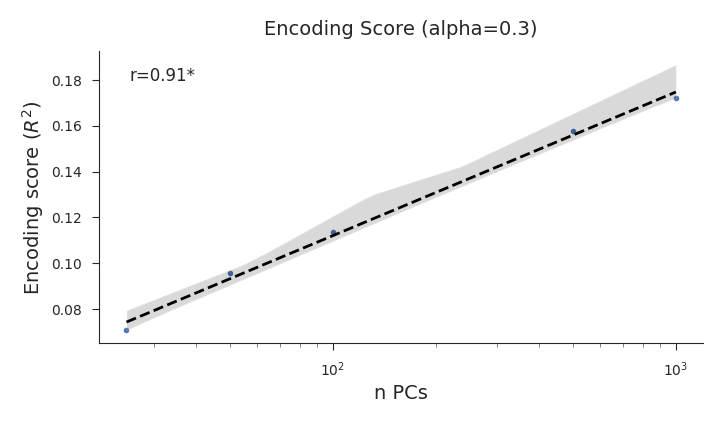

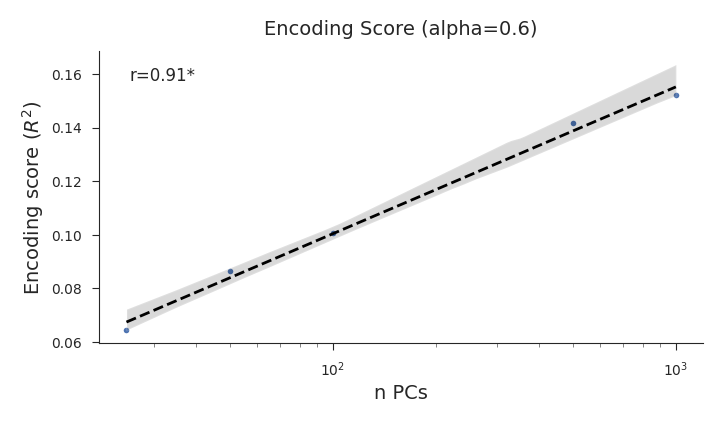

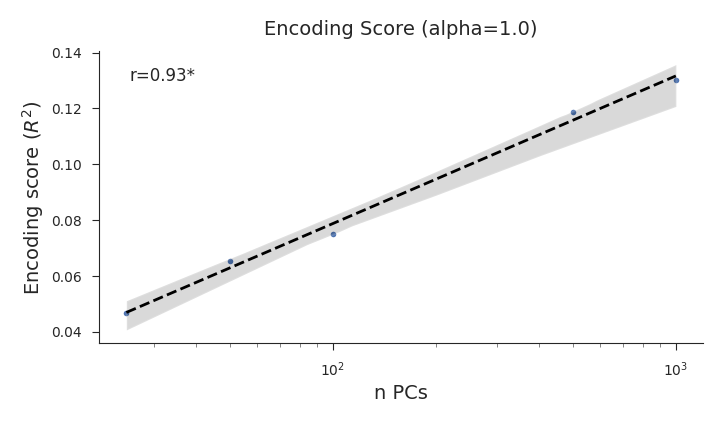

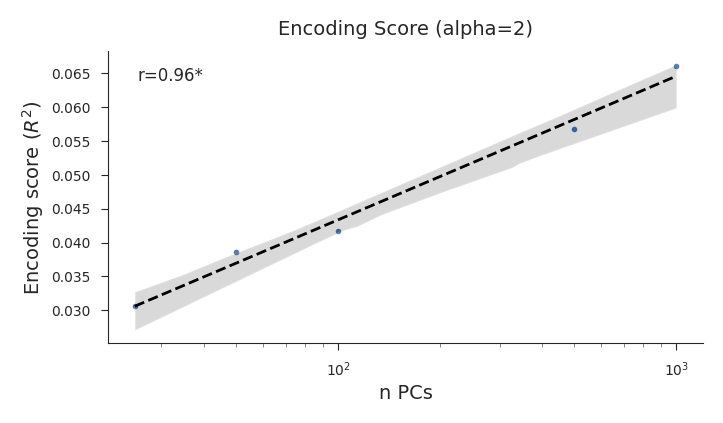

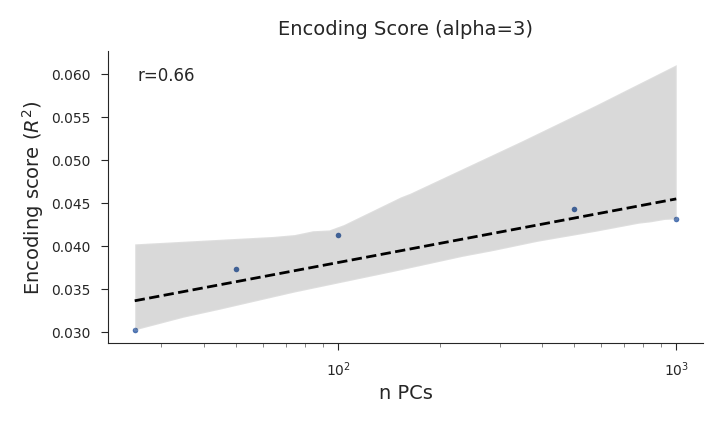

n_PCs p: 0.1513
n_PCs p: 0.2604
n_PCs p: 0.4636
n_PCs p: 0.5876
n_PCs p: 0.616


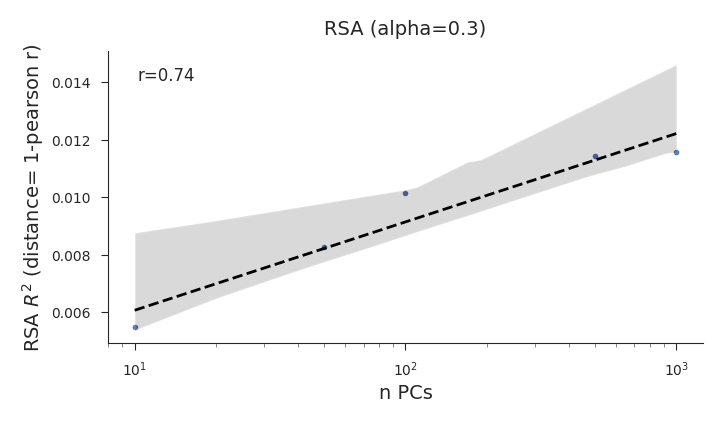

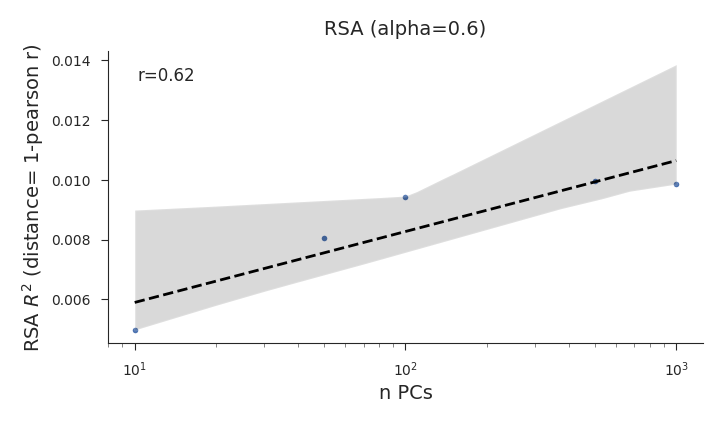

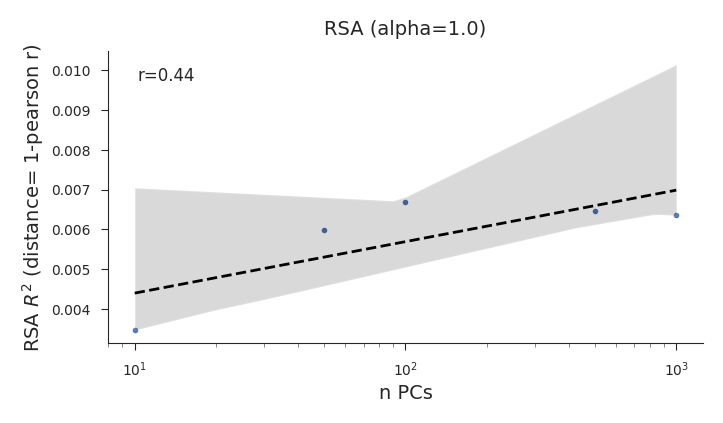

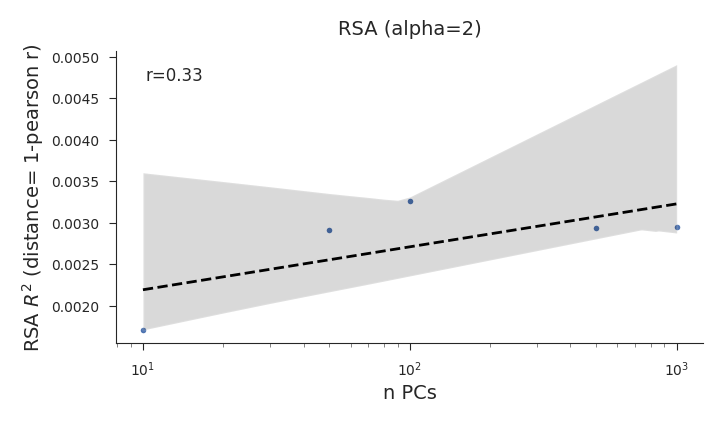

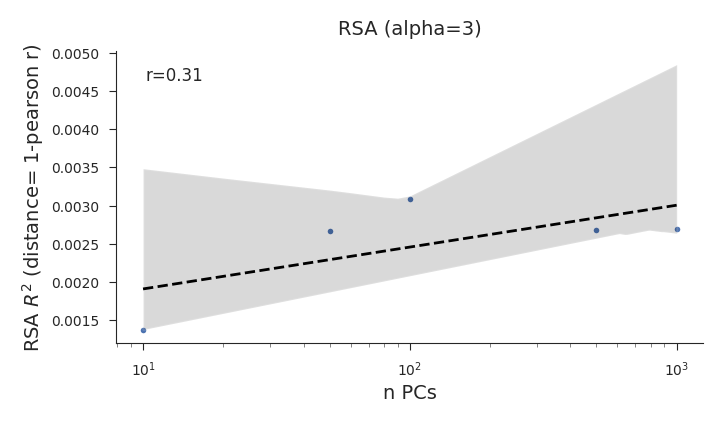

In [3]:
#Z Scoring then PCA (for scores & RSA.. and RDMs/umaps/)

#__Encoding score__

data = pd.read_csv(f'../../../results_marcc/capstone/nPCs/pooling/encoding_EigZC_allPCs|seed:0|pooling:PCA_zscore|nPCs:all|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
data['n_PCs']= data['source'].str.split('_').str[-1].astype(float)

alphas = [0.3, 0.6, 1.0, 2, 3]
for a in alphas:
    data_plot = data[ (data['kind'] == f'a_-{a}')]
    
    r, p = sp.stats.pearsonr(data_plot['n_PCs'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='n_PCs', y='score', 
                logx=True,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='n PCs', ylabel=r'Encoding score ($R^2$)', title=f'Encoding Score (alpha={a})', xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
plt.show()


#__RSA__

data = pd.read_csv(f'../../../results_marcc/capstone/nPCs/pooling/rsa_EigZC_allPCs|seed:0|pooling:PCA_zscore|nPCs:all|benchmark:dicarlo.MajajHong2015.IT.public-rsa.csv')
data['n_PCs']= data['source'].str.split('_').str[-1].astype(float)

alphas = [0.3, 0.6, 1.0, 2, 3]
for a in alphas:
    data_plot = data[ (data['kind'] == f'a_-{a}')]
    
    r, p = sp.stats.pearsonr(data_plot['n_PCs'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='n_PCs', y='score', 
                logx=True,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='n PCs', ylabel=r'RSA $R^2$ (distance= 1-pearson r)', title=f'RSA (alpha={a})', xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
plt.show()





n_PCs p: 0.0
n_PCs p: 0.0
n_PCs p: 0.0
n_PCs p: 0.0


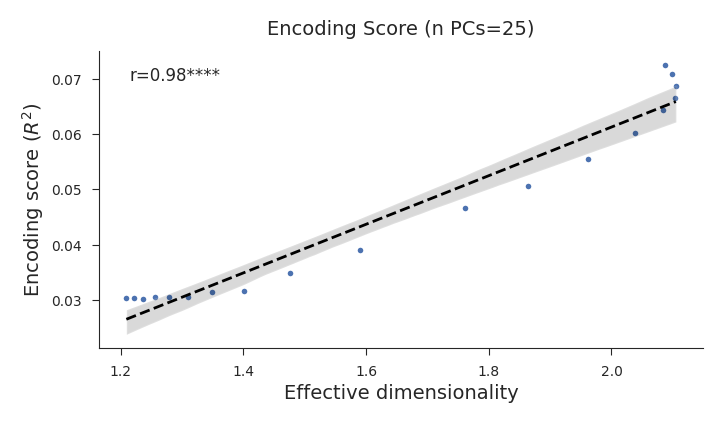

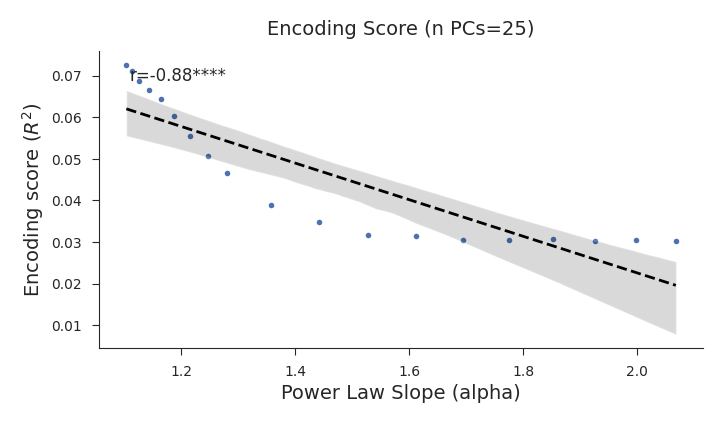

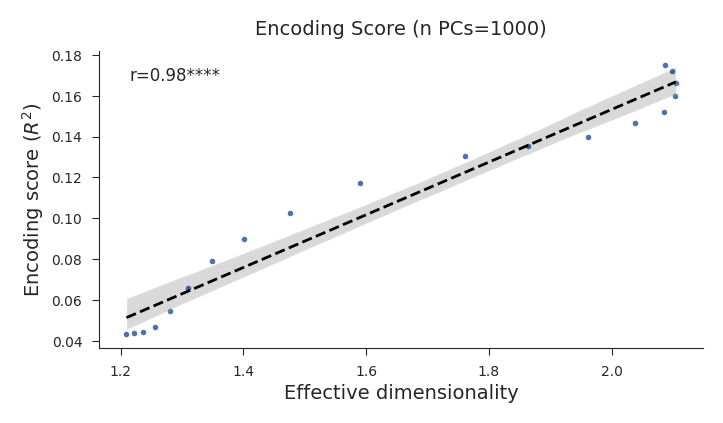

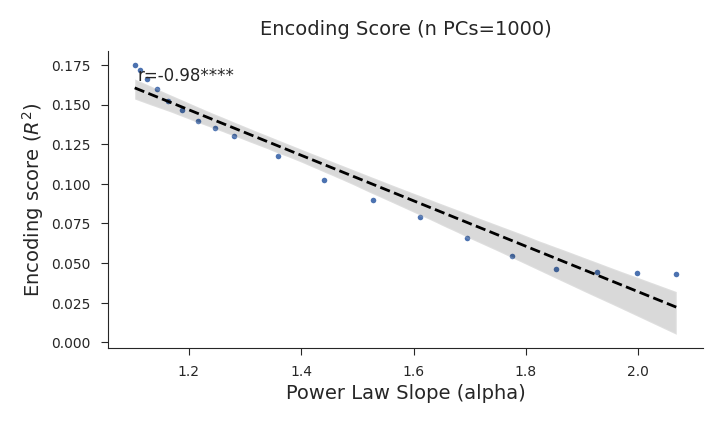

n_PCs p: 0.0
n_PCs p: 0.0
n_PCs p: 0.0
n_PCs p: 0.0


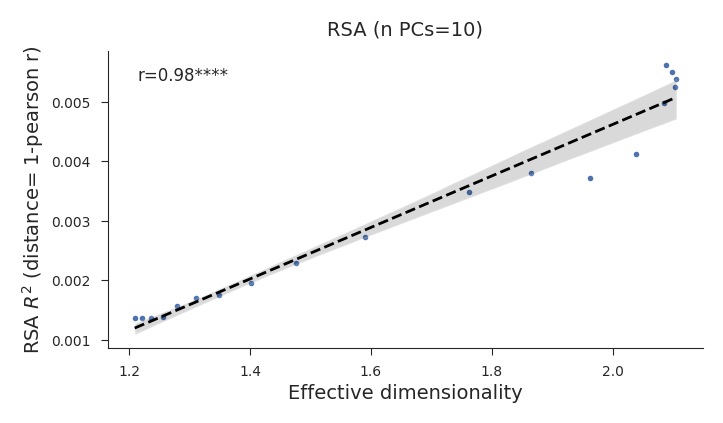

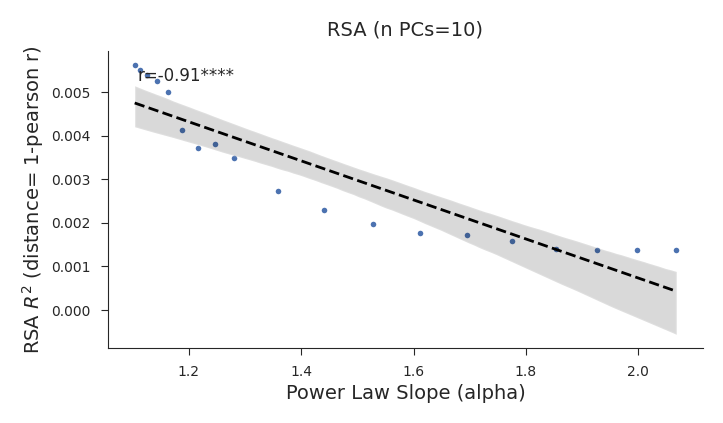

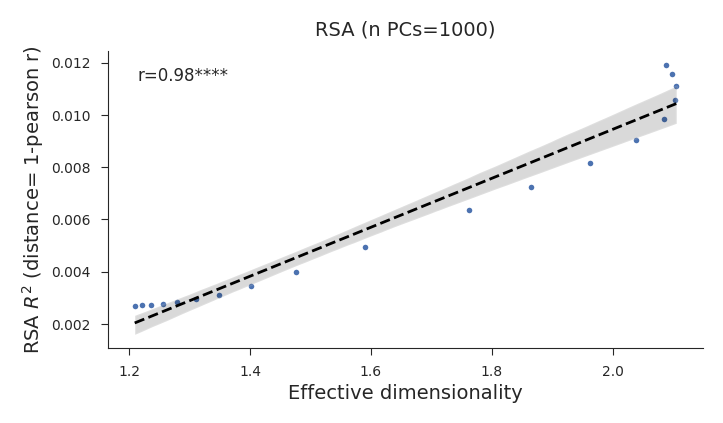

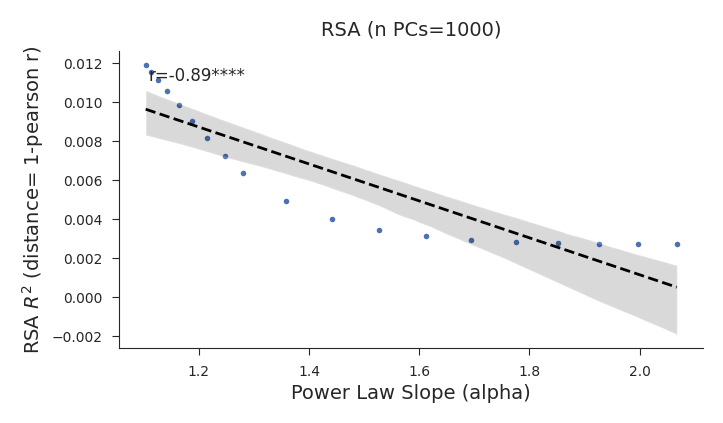

In [28]:
#zscore (no spectra)


#metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANalphas|dataset:imagenet|pooling:max|grayscale:False.csv')
#spectra = pd.read_csv(f'../../../results_marcc/capstone/eigspectra_ANalphas|dataset:imagenet|pooling:max|grayscale:False.csv')
#data = pd.merge(spectra, metrics, on=id_columns)
#data['id'] = data[id_columns].sum(axis='columns')

    
metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANalphas|dataset:imagenet|pooling:max|grayscale:False.csv')
encoding = pd.read_csv(f'../../../results_marcc/capstone/nPCs/pooling/encoding_EigZC_allPCs|seed:0|pooling:PCA_zscore|nPCs:all|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')

#n_PCs = encoding['source'].str.split('_').str[-1].unique().astype(int)
n_PCs = [25, 1000]

#__Encoding score__

for n in n_PCs:
    encoding_plot = encoding[ (encoding['source'] == f'pcs_{n}')]
    metrics['source'] = f'pcs_{n}'
    
    data_plot = pd.merge(encoding_plot, metrics, on=id_columns)
    data_plot['n_PCs'] = n
    
#ed
    r, p = sp.stats.pearsonr(data_plot['effective dimensionality'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='effective dimensionality', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title=f'Encoding Score (n PCs={n})')#, xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
    
#alpha
    r, p = sp.stats.pearsonr(data_plot['alpha'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='alpha', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'Encoding score ($R^2$)', title=f'Encoding Score (n PCs={n})')#, xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
    
plt.show()


#__RSA__

encoding = pd.read_csv(f'../../../results_marcc/capstone/nPCs/pooling/rsa_EigZC_allPCs|seed:0|pooling:PCA_zscore|nPCs:all|benchmark:dicarlo.MajajHong2015.IT.public-rsa.csv')

#n_PCs = encoding['source'].str.split('_').str[-1].unique().astype(int)
n_PCs = [10, 1000]

for n in n_PCs:
    encoding_plot = encoding[ (encoding['source'] == f'pcs_{n}')]
    metrics['source'] = f'pcs_{n}'
    
    data_plot = pd.merge(encoding_plot, metrics, on=id_columns)
    data_plot['n_PCs'] = n

#ed
    r, p = sp.stats.pearsonr(data_plot['effective dimensionality'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='effective dimensionality', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Effective dimensionality', ylabel=r'RSA $R^2$ (distance= 1-pearson r)', title=f'RSA (n PCs={n})')#, xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
    
#alpha
    r, p = sp.stats.pearsonr(data_plot['alpha'], data_plot['score'])
    print('n_PCs p:', round(p, 4))
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
    sns.regplot(data=data_plot, x='alpha', y='score', 
                logx=False,
                scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                ax=ax)
    ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'RSA $R^2$ (distance= 1-pearson r)', title=f'RSA (n PCs={n})')#, xscale='log')
    ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
    #ax.set_xlim(0.8, 270)
    #ax.set_ylim(bottom=0, top=0.65)
plt.show()



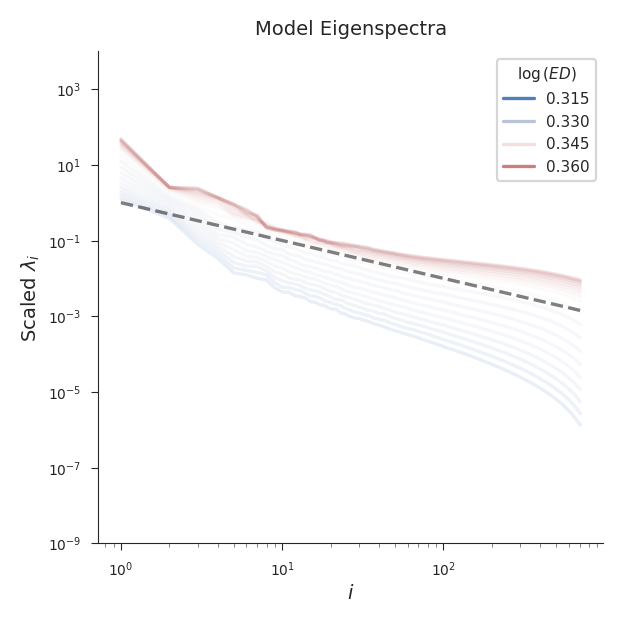

In [3]:
#zscore eigspectra
#**dumb, it's also max pooled..

data = pd.merge(
    pd.read_csv(f'../../../results_marcc/capstone/nPCs/eigspectra_AN_zscore|seed:0|dataset:imagenet|pooling:max|grayscale:False.csv'),
    pd.read_csv(f'../../../results_marcc/capstone/nPCs/eigmetrics_AN_zscore|seed:0|dataset:imagenet|pooling:max|grayscale:False.csv'),
    on=id_columns)

data['id'] = data[id_columns].sum(axis='columns')

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Model Eigenspectra')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()


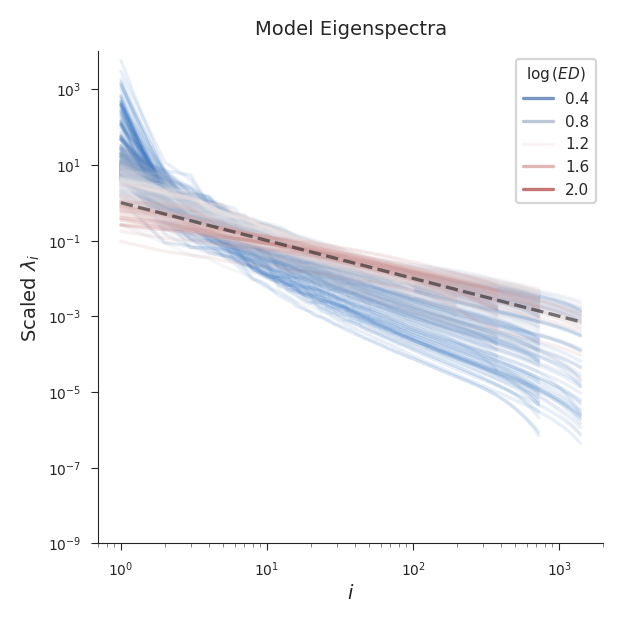

ED p 0.0
logED 0.81 0.0


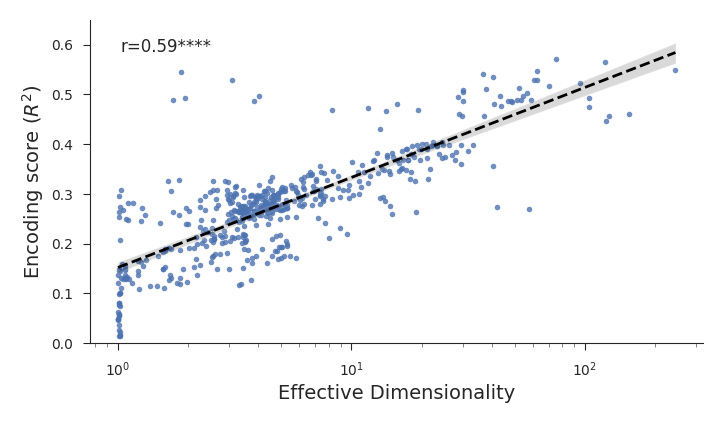

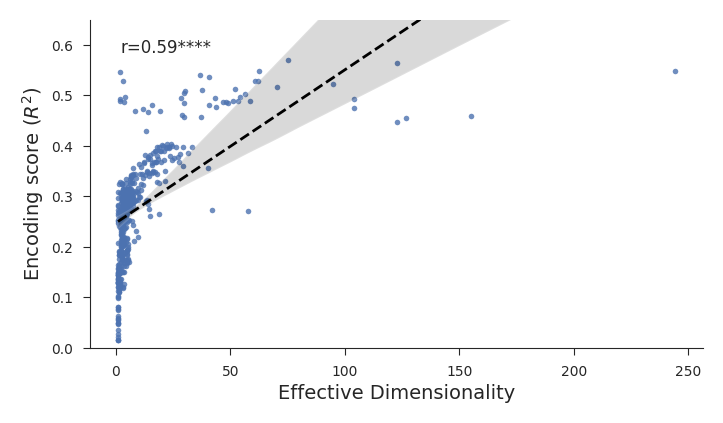

alpha p 0.0
logalpha -0.7 0.0


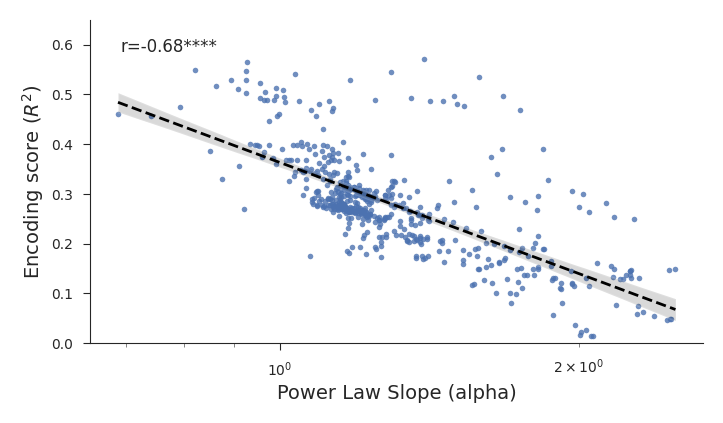

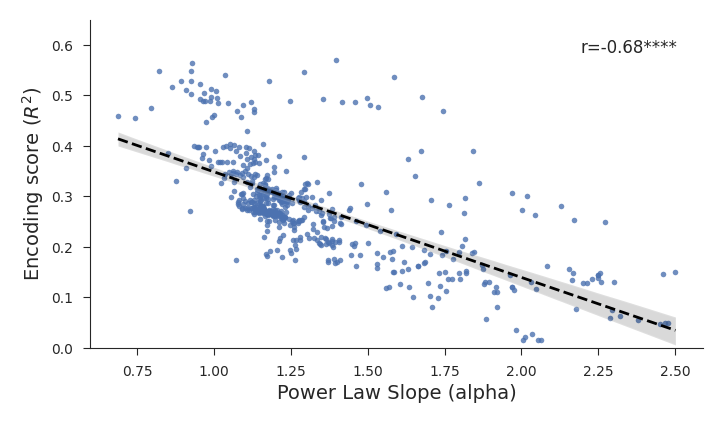

In [21]:
#Eric's plot
# - pearson r computed with ED and score
# - plotted with ED in log scale and a linear fit to logED vs score
#   - plotting in logx shows the points in a clearer way, and computing the linear fit line in with logx keeps it appearing linear
#   - but, pearson r for ED vs score (not logED) is reported because that is what we're more interested in (I guess)

#from plotting import annotate_corr

dataset = 'imagenet'
#'../../../results_marcc/reproductions/eigspectra|dataset:{dataset}|pooling:True|grayscale:False.csv'


data = pd.merge(pd.read_csv(f'../../../results_marcc/reproductions/eigspectra|dataset:{dataset}|pooling:True|grayscale:False.csv'),
                pd.read_csv(f'../../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Model Eigenspectra')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()


#_Enoding score_
data = pd.merge(pd.read_csv(f'../../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

#___original___
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])
print('ED p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

data['log_ed'] = np.log10(data['effective dimensionality'])
rlog, plog = sp.stats.pearsonr(data['log_ed'], data['score'])
print('logED', round(rlog,2), round(plog, 4))

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective Dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
#ax.set_xlim(0.8, 270)
ax.set_ylim(bottom=0, top=0.65)
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()

#___no logs___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective Dimensionality', ylabel=r'Encoding score ($R^2$)')
#ax.set_xlim(0.8, 270)
ax.set_ylim(bottom=0, top=0.65)
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()


#alpha
data = pd.merge(pd.read_csv(f'../../../results_marcc/reproductions/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../../results_marcc/reproductions/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

#___original___
r, p = sp.stats.pearsonr(data['alpha'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

data['log_alpha'] = np.log10(data['alpha'])
rlog, plog = sp.stats.pearsonr(data['log_alpha'], data['score'])
print('logalpha', round(rlog,2), round(plog, 4))

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'Encoding score ($R^2$)', xscale='log')
#ax.set_xlim(0.4, 3.3)
ax.set_ylim(bottom=0, top=0.65)
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()

#___no logs___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Power Law Slope (alpha)', ylabel=r'Encoding score ($R^2$)')
#ax.set_xlim(0.4, 3.3)
ax.set_ylim(bottom=0, top=0.65)
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()


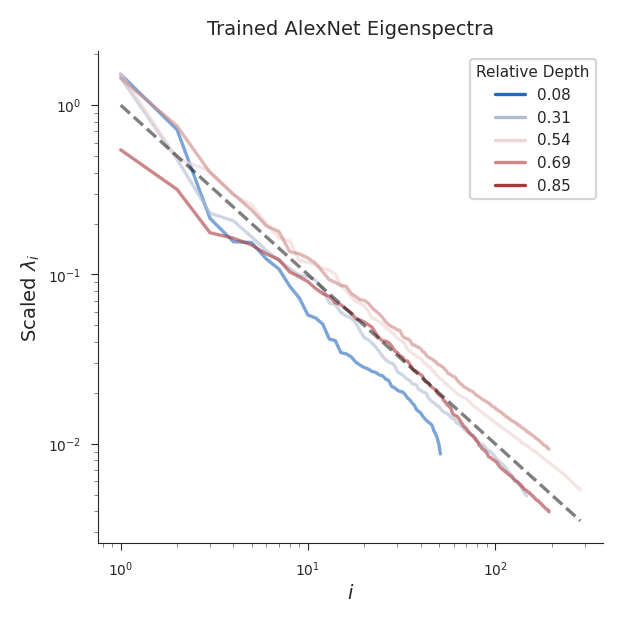

ED p 0.0599
logED 0.96 0.0086


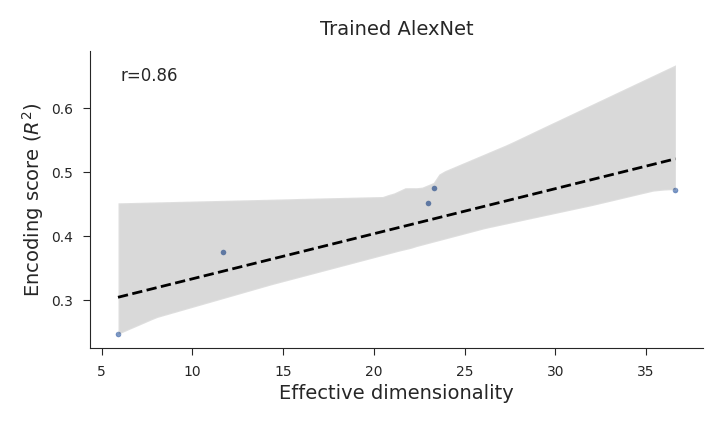

alpha p 0.0002
logalpha -1.0 0.0


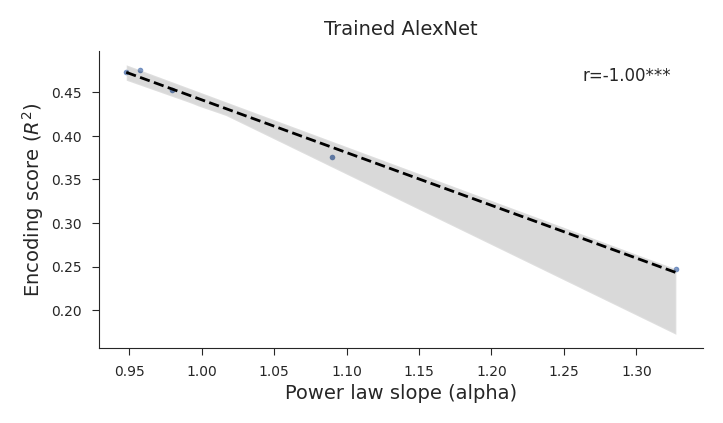

relative depth p 0.0187


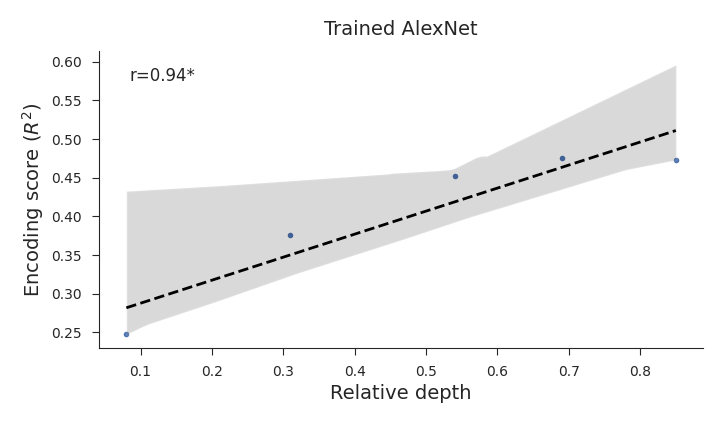

relative depth p 0.006


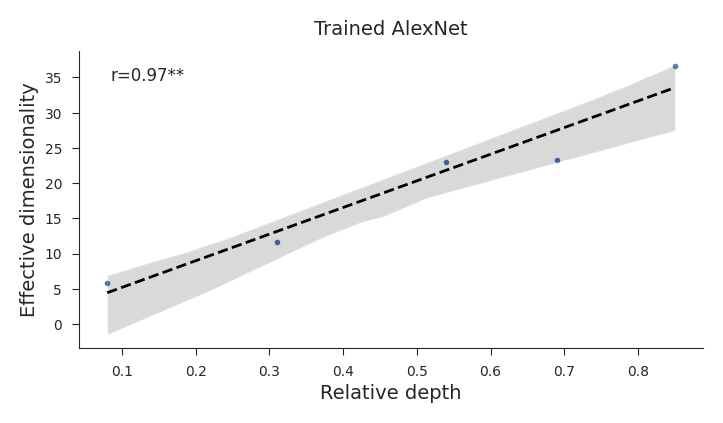

relative depth p 0.0252


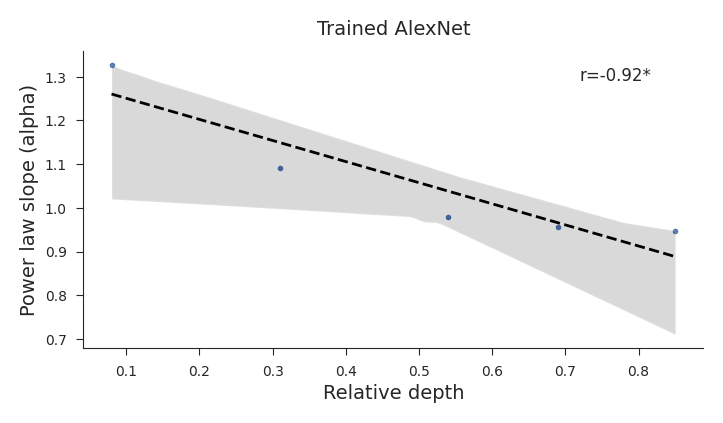

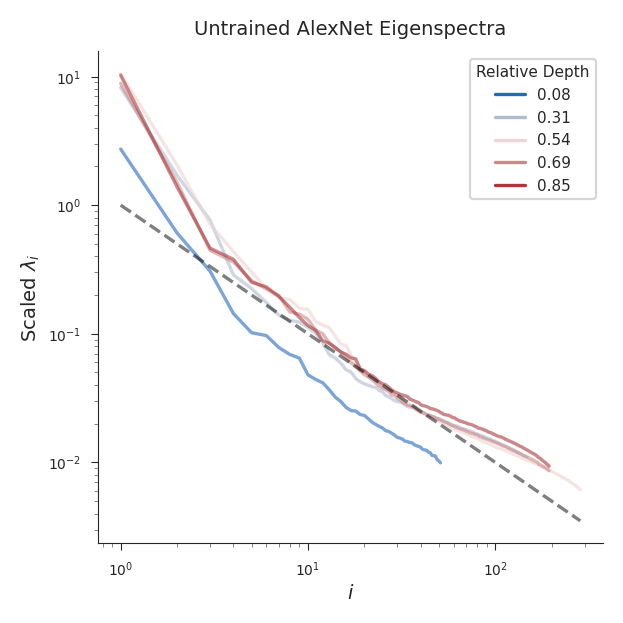

ED p 0.4952
logED -0.41 0.4954


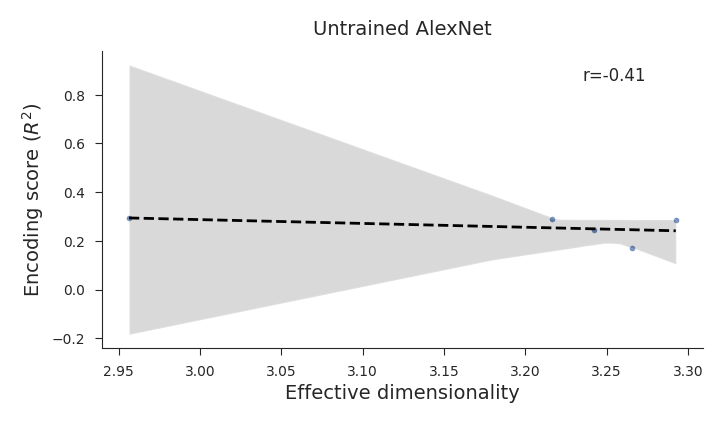

alpha p 0.7177
logalpha -0.23 0.7071


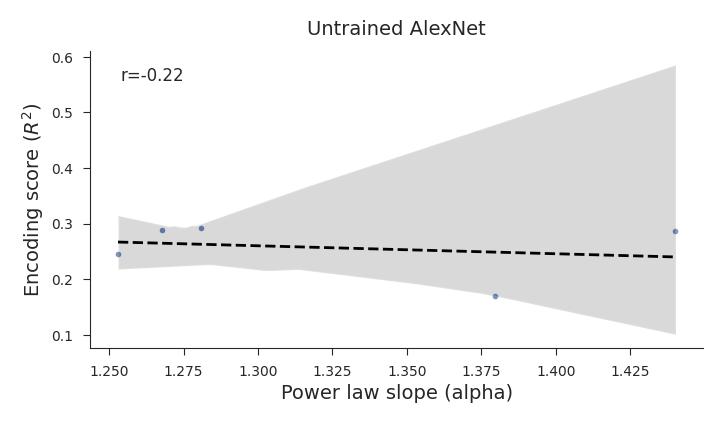

relative depth p 0.0276


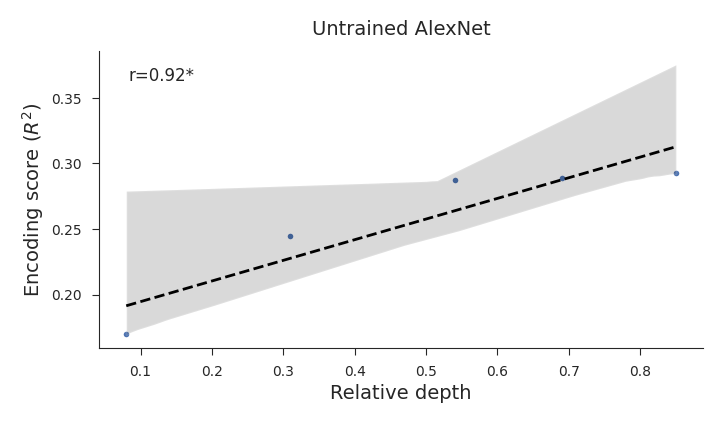

relative depth p 0.1997


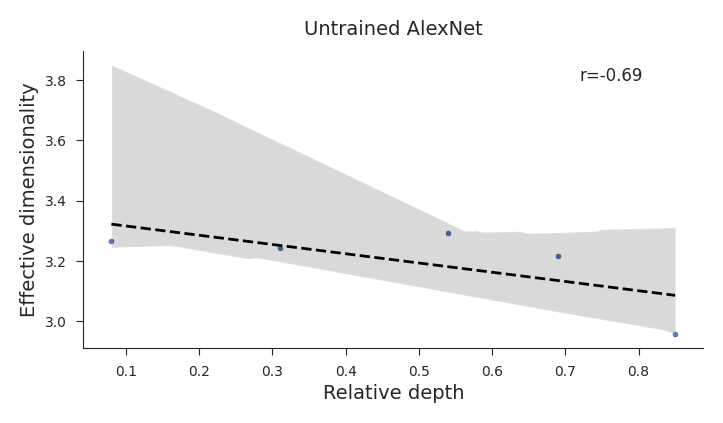

relative depth p 0.6112


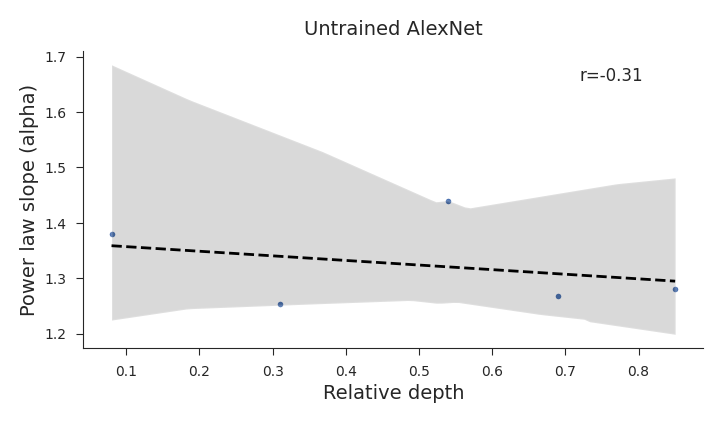

In [20]:
#Layer depth
# - x and y limits?
# - logs

dataset = 'imagenet'
pooling = 'max'
model = 'AlexNet'
model_depth = 13
# - model_depth=8? (if no relu)

#____Trained____

metrics = pd.read_csv(f'../../../results_marcc/untrained/eigmetrics_pytrch|dataset:{dataset}|pooling:{pooling}|grayscale:False.csv')
metrics = metrics[ (metrics['architecture'] == model)]
spectra = pd.read_csv(f'../../../results_marcc/untrained/eigspectra_pytrch|dataset:{dataset}|pooling:{pooling}|grayscale:False.csv')
spectra = spectra[ (spectra['architecture'] == model)]

data = pd.merge(metrics, spectra, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
layer_depth = round( data['layer'].str.split(pat='.').str[1].astype(float) / model_depth, 2)
data['layer_depth'] = layer_depth

#__Eigenspectrum__

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
#data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='layer_depth', legend='full',
             units='id', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Trained AlexNet Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'Relative Depth')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()


#__Encoding Score__
encoding = pd.read_csv(f'../../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
encoding = encoding[ (encoding['architecture'] == model)]
encoding = encoding[ (encoding['kind'] == 'Supervised')]
data = pd.merge(metrics, encoding, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
layer_depth = round( data['layer'].str.split(pat='.').str[1].astype(float) / model_depth, 2)
data['layer_depth'] = layer_depth

#_Effective dimensionality_
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])
print('ED p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

data['log_ed'] = np.log10(data['effective dimensionality'])
rlog, plog = sp.stats.pearsonr(data['log_ed'], data['score'])
print('logED', round(rlog,2), round(plog, 4))

#___no log___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title='Trained AlexNet')
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()


#_alpha_

#___orignal___
r, p = sp.stats.pearsonr(data['alpha'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

data['log_alpha'] = np.log10(data['alpha'])
rlog, plog = sp.stats.pearsonr(data['log_alpha'], data['score'])
print('logalpha', round(rlog,2), round(plog, 4))

#___no logs___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
#custom_palette = sns.diverging_palette(h_neg=220, h_pos=20, sep=1, n=len(data['layer_depth']) )#, as_cmap=True)
sns.regplot(data=data, x='alpha', y='score',
            logx=False,
            #scatter_kws={'alpha': 1, 's': 6, 'linewidth': 0.2, 'edgecolors': 'black', 'facecolors': custom_palette }, 
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, #'alpha': 0.8
            ax=ax)
ax.set(xlabel='Power law slope (alpha)', ylabel=r'Encoding score ($R^2$)', title='Trained AlexNet')
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()


#_Relative depth_
r, p = sp.stats.pearsonr(data['layer_depth'], data['score'])
print('relative depth p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='layer_depth', y='score', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Relative depth', ylabel=r'Encoding score ($R^2$)', title='Trained AlexNet')
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()

#_Relative depth & ED_
r, p = sp.stats.pearsonr(data['layer_depth'], data['effective dimensionality'])
print('relative depth p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='layer_depth', y='effective dimensionality', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Relative depth', ylabel=r'Effective dimensionality', title='Trained AlexNet')#, xscale='log')
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()

#_Relative depth & alpha_
r, p = sp.stats.pearsonr(data['layer_depth'], data['alpha'])
print('relative depth p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='layer_depth', y='alpha', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Relative depth', ylabel=r'Power law slope (alpha)', title='Trained AlexNet')#, xscale='log')
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()



#____Untrained____

metrics = pd.read_csv(f'../../../results_marcc/untrained/eigmetrics_unt|dataset:{dataset}|pooling:{pooling}|grayscale:False.csv')
metrics = metrics[ (metrics['architecture'] == model)]
spectra = pd.read_csv(f'../../../results_marcc/untrained/eigspectra_unt|dataset:{dataset}|pooling:{pooling}|grayscale:False.csv')
spectra = spectra[ (spectra['architecture'] == model)]

data = pd.merge(metrics, spectra, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
layer_depth = round( data['layer'].str.split(pat='.').str[1].astype(float) / model_depth, 2)
data['layer_depth'] = layer_depth

#__Eigenspectrum__
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var


fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='layer_depth', legend='full',
             units='id', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Untrained AlexNet Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'Relative Depth')
plt.show()


#__Encoding Score__
encoding = pd.read_csv(f'../../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
encoding = encoding[ (encoding['architecture'] == model)]
encoding = encoding[ (encoding['kind'] == 'Untrained')]
data = pd.merge(metrics, encoding, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
layer_depth = round( data['layer'].str.split(pat='.').str[1].astype(float) / model_depth, 2)
data['layer_depth'] = layer_depth

#_Effective dimensionality_
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])
print('ED p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

data['log_ed'] = np.log10(data['effective dimensionality'])
rlog, plog = sp.stats.pearsonr(data['log_ed'], data['score'])
print('logED', round(rlog,2), round(plog, 4))


#___no log___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title='Untrained AlexNet')
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()


#_alpha_
r, p = sp.stats.pearsonr(data['alpha'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

data['log_alpha'] = np.log10(data['alpha'])
rlog, plog = sp.stats.pearsonr(data['log_alpha'], data['score'])
print('logalpha', round(rlog,2), round(plog, 4))


#___no log___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score',
            logx=False,
            #scatter_kws={'alpha': 1, 's': 6, 'linewidth': 0.2, 'edgecolors': 'black', 'facecolors': custom_palette }, 
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, #'alpha': 0.8
            ax=ax)
ax.set(xlabel='Power law slope (alpha)', ylabel=r'Encoding score ($R^2$)', title='Untrained AlexNet')
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()


#_Relative depth & score_
r, p = sp.stats.pearsonr(data['layer_depth'], data['score'])
print('relative depth p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='layer_depth', y='score', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Relative depth', ylabel=r'Encoding score ($R^2$)', title='Untrained AlexNet')#, xscale='log')
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()

#_Relative depth & ED_
r, p = sp.stats.pearsonr(data['layer_depth'], data['effective dimensionality'])
print('relative depth p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='layer_depth', y='effective dimensionality', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Relative depth', ylabel=r'Effective dimensionality', title='Untrained AlexNet')#, xscale='log')
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()

#_Relative depth & alpha_
r, p = sp.stats.pearsonr(data['layer_depth'], data['alpha'])
print('relative depth p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='layer_depth', y='alpha', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Relative depth', ylabel=r'Power law slope (alpha)', title='Untrained AlexNet')#, xscale='log')
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
plt.show()

In [53]:

metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANinit_all|dataset:imagenet|pooling:max|grayscale:False.csv')
#spectra_all = pd.read_csv(f'../../../results_marcc/capstone/eigspectra_ANinit_all|dataset:imagenet|pooling:max|grayscale:False.csv', index_col=0)
encoding = pd.read_csv(f'../../../results_marcc/capstone/encoding_ANinit_all|seed:0|pooling:layerPCA|nPCs:1000|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
metrics['source'] = encoding['source']
data = pd.merge(metrics, encoding, on=id_columns)

print(data)



   layer  effective dimensionality  80% variance     alpha architecture  \
0     c2                  2.096120          15.0  1.081588     AtlasNet   
1     c2                  2.047857          11.0  1.091054     AtlasNet   
2     c2                  2.096120          15.0  1.081588     AtlasNet   
3     c2                  2.096120          15.0  1.081588     AtlasNet   
4     c2                  2.096120          15.0  1.081588     AtlasNet   
5     c2                  2.096120          15.0  1.081588     AtlasNet   
6     c2                  2.096120          15.0  1.081588     AtlasNet   
7     c2                  2.096120          15.0  1.081588     AtlasNet   
8     c2                  2.096120          15.0  1.081588     AtlasNet   
9     c2                  2.096120          15.0  1.081588     AtlasNet   
10    c2                  2.090805          14.0  1.082586     AtlasNet   
11    c2                  2.047856          11.0  1.091054     AtlasNet   
12    c2                 

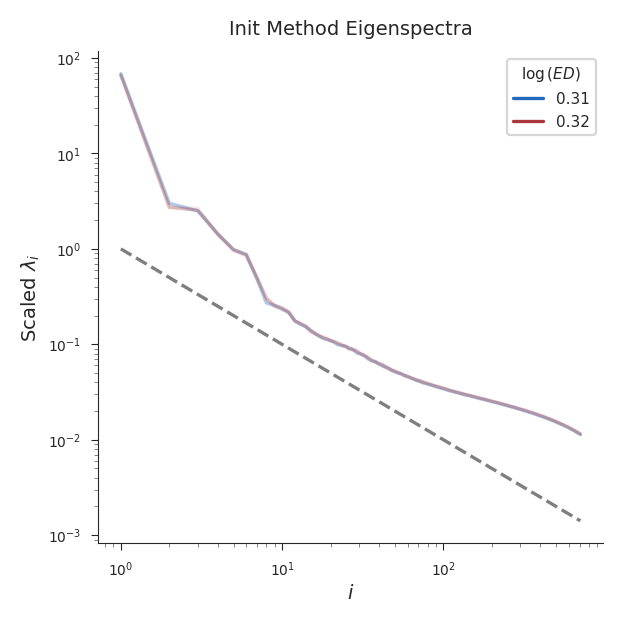

ED p 0.0032


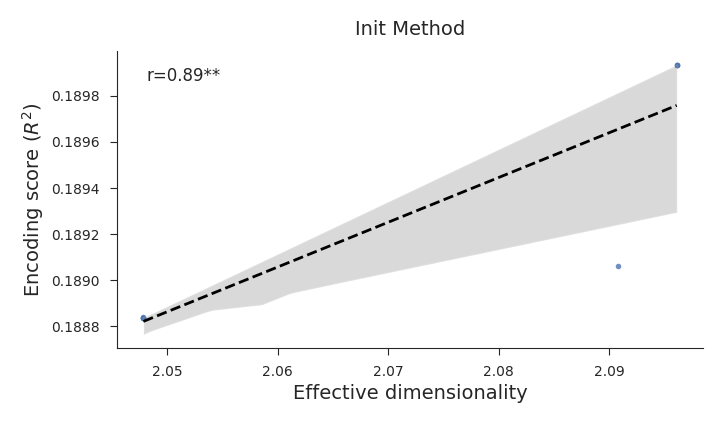

alpha p 0.0033


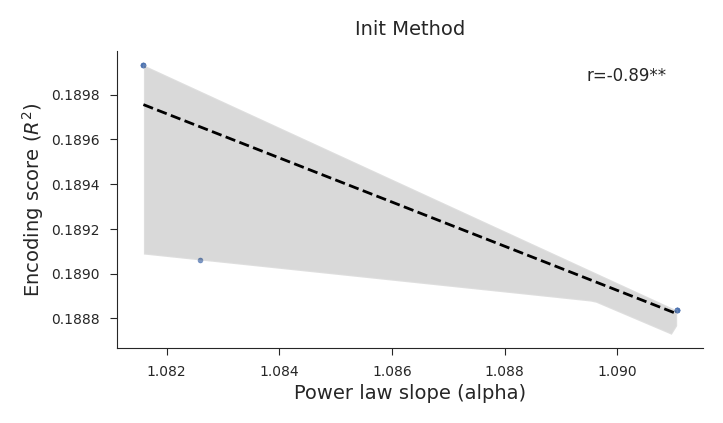

alpha p 0.0516


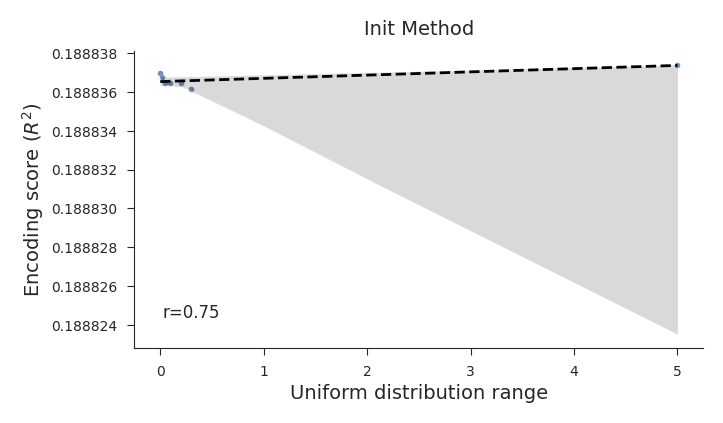

alpha p 0.0392


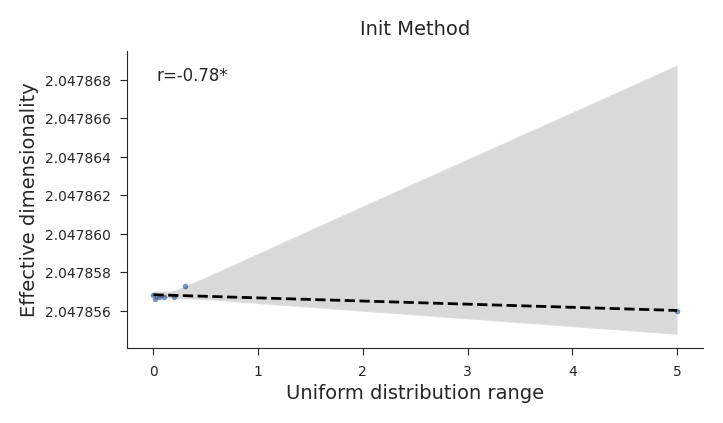

alpha p 0.3689


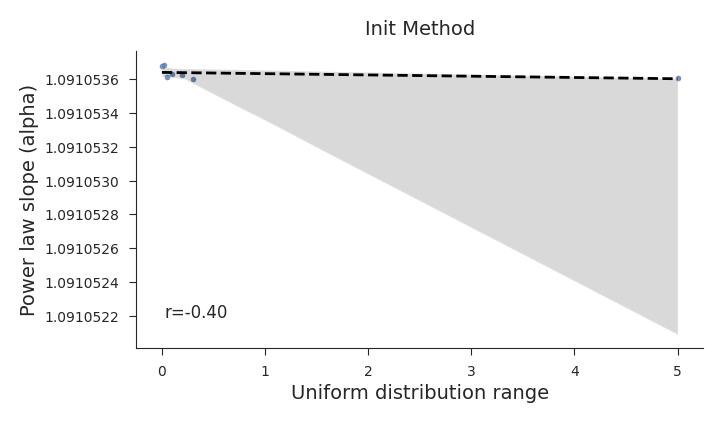

alpha p 0.2456


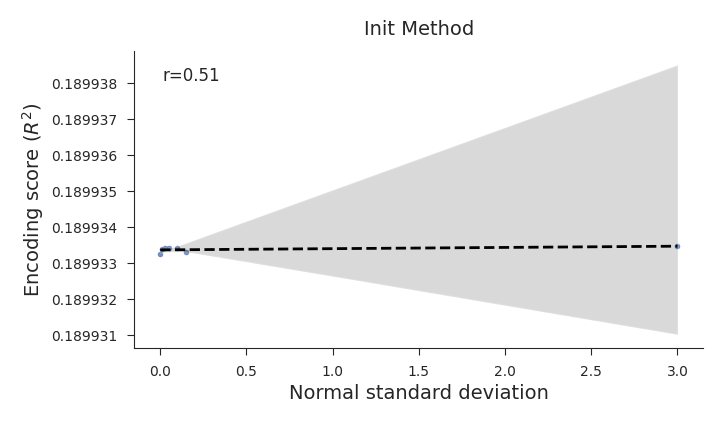

alpha p 0.0071


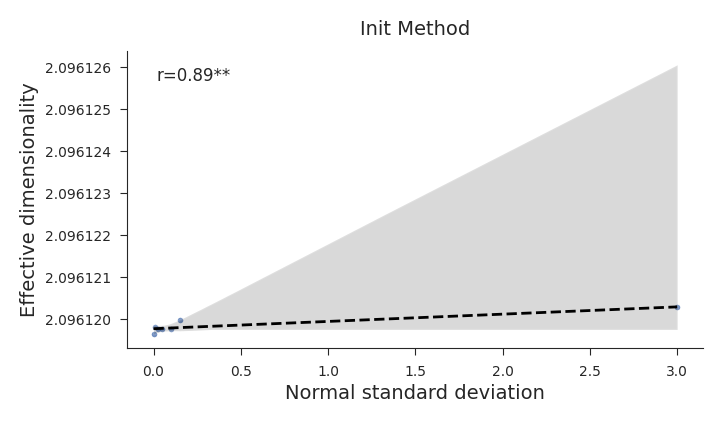

alpha p 0.9761


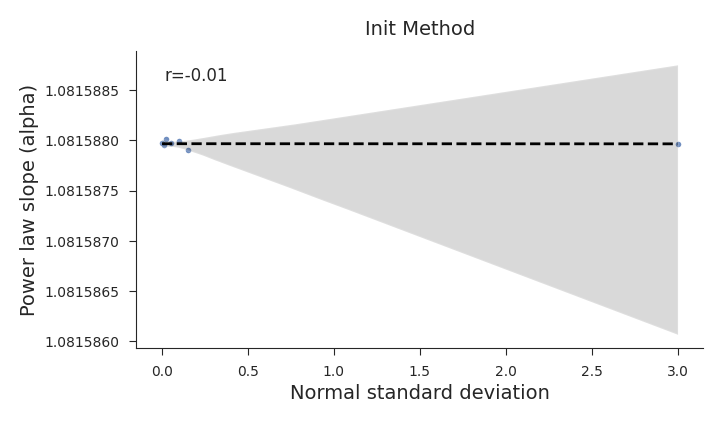

In [65]:
#Init Method:
# ** yaxis
#score: standard=uniform, orthogonal, normal
#ED: standard=uniform, orthonal, normal
#alpha: standard=uniform, orthonal, normal
# - worst to best

metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANinit_use|dataset:imagenet|pooling:max|grayscale:False.csv')
spectra = pd.read_csv(f'../../../results_marcc/capstone/eigspectra_ANinit_use|dataset:imagenet|pooling:max|grayscale:False.csv')
#metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANinit_all|dataset:imagenet|pooling:max|grayscale:False.csv')
#spectra_all = pd.read_csv(f'../../../results_marcc/capstone/eigspectra_ANinit_all|dataset:imagenet|pooling:max|grayscale:False.csv')

data = pd.merge(metrics, spectra, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')


# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = round(np.log10(data['effective dimensionality']), 2)

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Init Method Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'$\log{(ED)}$')
plt.show()


#_Enoding score_

encoding = pd.read_csv(f'../../../results_marcc/capstone/encoding_ANinit_use|seed:0|pooling:layerPCA|nPCs:1000|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
#encoding = pd.read_csv(f'../../../results_marcc/capstone/encoding_ANinit_all|seed:0|pooling:layerPCA|nPCs:1000|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
metrics.loc[:, 'source'] = metrics['source'].replace({'a+pcs_NA': 'a+pcs_1000'})
data = pd.merge(encoding, metrics, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

#___original___
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])
print('ED p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''


#___no logs___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title='Init Method')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#alpha

#___original___
r, p = sp.stats.pearsonr(data['alpha'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

#___no logs___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Power law slope (alpha)', ylabel=r'Encoding score ($R^2$)', title='Init Method')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()



#Uniform ranges
metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANinit_all|dataset:imagenet|pooling:max|grayscale:False.csv')
#spectra_all = pd.read_csv(f'../../../results_marcc/capstone/eigspectra_ANinit_all|dataset:imagenet|pooling:max|grayscale:False.csv', index_col=0)
encoding = pd.read_csv(f'../../../results_marcc/capstone/encoding_ANinit_all|seed:0|pooling:layerPCA|nPCs:1000|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
metrics['source'] = encoding['source']
data = pd.merge(metrics, encoding, on=id_columns)

uniform_check = []
for kind in data['kind'].str.split('.').str[0]:
    if 'uniform' in kind:
        uniform_check.append(True)
    else:
        uniform_check.append(False)

data = data[(uniform_check)]
data = data[ (data['kind'].str.split('.').str[0] != 'init_kai_uniform') ]
data = data[ (data['kind'].str.split('.').str[0] != 'init_uniform') ]
data['range'] = data['kind'].str.split('m').str[-1].astype(float)


#range and score
r, p = sp.stats.pearsonr(data['range'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='range', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Uniform distribution range', ylabel=r'Encoding score ($R^2$)', title='Init Method')
ax.text(.05, .1, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
ax.ticklabel_format(axis='y', useOffset=False)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#range and ED
r, p = sp.stats.pearsonr(data['range'], data['effective dimensionality'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='range', y='effective dimensionality', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Uniform distribution range', ylabel=r'Effective dimensionality', title='Init Method')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
ax.ticklabel_format(axis='y', useOffset=False)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#range and alpha
r, p = sp.stats.pearsonr(data['range'], data['alpha'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='range', y='alpha', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Uniform distribution range', ylabel=r'Power law slope (alpha)', title='Init Method')
ax.text(.05, .1, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
ax.ticklabel_format(axis='y', useOffset=False)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()



#Normal standard deviations
metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANinit_all|dataset:imagenet|pooling:max|grayscale:False.csv')
#spectra_all = pd.read_csv(f'../../../results_marcc/capstone/eigspectra_ANinit_all|dataset:imagenet|pooling:max|grayscale:False.csv', index_col=0)
encoding = pd.read_csv(f'../../../results_marcc/capstone/encoding_ANinit_all|seed:0|pooling:layerPCA|nPCs:1000|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
metrics['source'] = encoding['source']
data = pd.merge(metrics, encoding, on=id_columns)

normal_check = []
for kind in data['kind'].str.split('.').str[0]:
    if 'normal' in kind:
        normal_check.append(True)
    else:
        normal_check.append(False)

data = data[(normal_check)]
data = data[ (data['kind'].str.split('.').str[0] != 'init_kai_normal') ]
data = data[ (data['kind'].str.split('.').str[0] != 'init_normal') ]
data['range'] = data['kind'].str.split('l').str[-1].astype(float)


#range and score
r, p = sp.stats.pearsonr(data['range'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='range', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Normal standard deviation', ylabel=r'Encoding score ($R^2$)', title='Init Method')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
ax.ticklabel_format(axis='y', useOffset=False)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#range and ED
r, p = sp.stats.pearsonr(data['range'], data['effective dimensionality'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='range', y='effective dimensionality', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Normal standard deviation', ylabel=r'Effective dimensionality', title='Init Method')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
ax.ticklabel_format(axis='y', useOffset=False)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#range and alpha
r, p = sp.stats.pearsonr(data['range'], data['alpha'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='range', y='alpha', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Normal standard deviation', ylabel=r'Power law slope (alpha)', title='Init Method')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
ax.ticklabel_format(axis='y', useOffset=False)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()



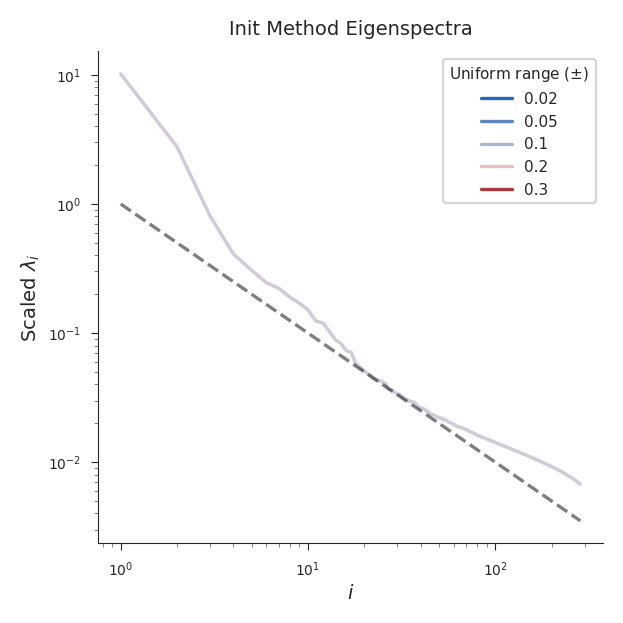

         layer     score  score_error architecture    task              kind  \
12  features.7  0.284617     0.003299      AlexNet  seed_0  init_uniform0.02   
17  features.7  0.282342     0.003539      AlexNet  seed_0  init_uniform0.05   
22  features.7  0.282118     0.003493      AlexNet  seed_0   init_uniform0.1   
27  features.7  0.281767     0.003485      AlexNet  seed_0   init_uniform0.2   
32  features.7  0.281745     0.003472      AlexNet  seed_0   init_uniform0.3   

      source  effective dimensionality  80% variance     alpha  range  
12  pcs_1000                  3.668663          21.0  1.782961   0.02  
17  pcs_1000                  3.681978          21.0  1.366249   0.05  
22  pcs_1000                  3.681337          21.0  1.352165   0.10  
27  pcs_1000                  3.681312          21.0  1.348104   0.20  
32  pcs_1000                  3.681388          20.0  1.347119   0.30  
ED p 0.0065


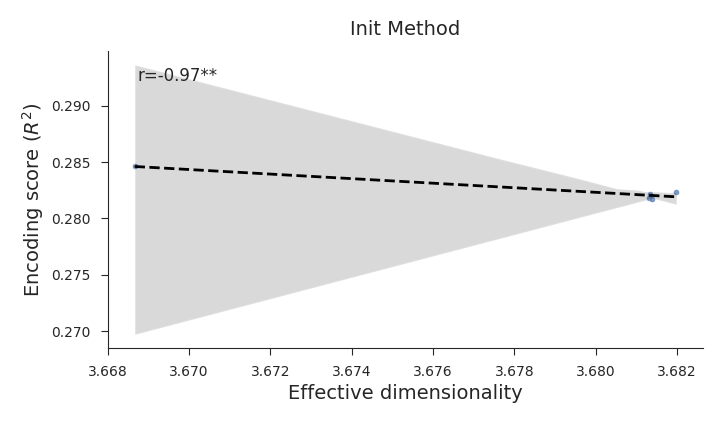

alpha p 0.0022


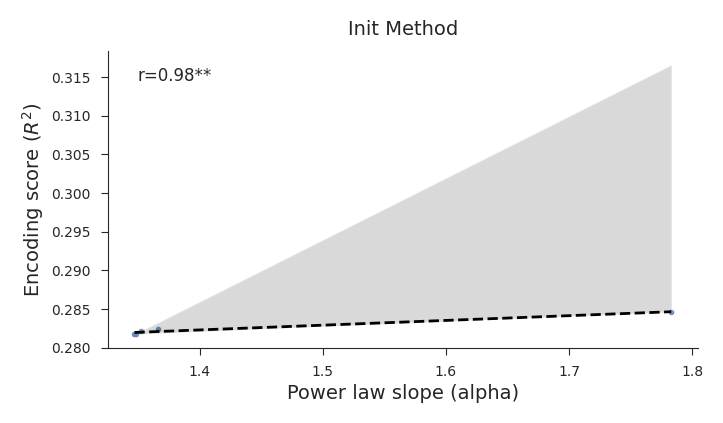

alpha p 0.1853


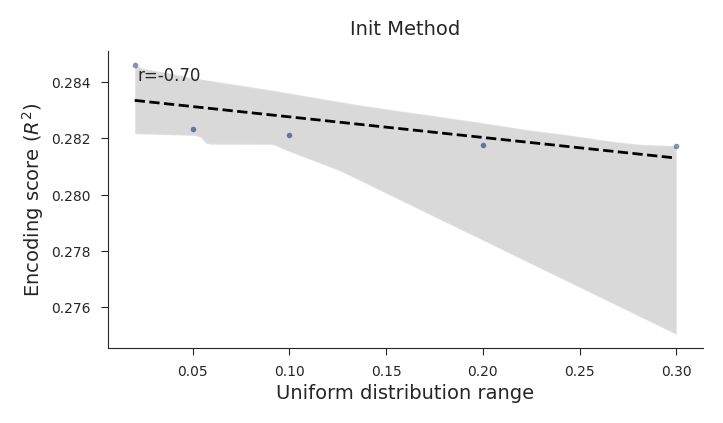

alpha p 0.361


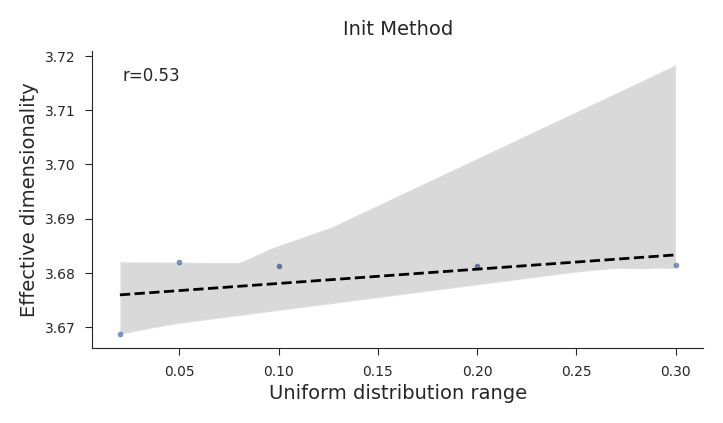

alpha p 0.3053


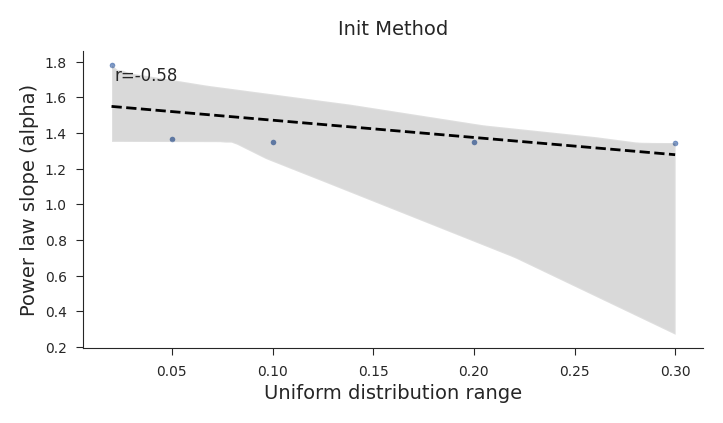

In [4]:
#AlexNet Init
# - Uniform range & Normal st. dev.:


metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_alex_init|seed:0|dataset:imagenet|pooling:max|grayscale:False.csv')
spectra = pd.read_csv(f'../../../results_marcc/capstone/eigspectra_alex_init|seed:0|dataset:imagenet|pooling:max|grayscale:False.csv')
data = pd.merge(metrics, spectra, on=id_columns)
data = data[ (data['layer']=='features.7')]
#data = data[ (data['kind'] != 'init_kai_uniform')]
#data = data[ (data['kind'] != 'init_kai_normal')]
#data = data[ (data['kind'] != 'init_orthogonal')]
#data = data[ (data['kind'] != 'init_orthogonal')]
data = data[ (data['kind'].str.split('0').str[0] == 'init_uniform')]
data['range'] = data['kind'].str.split('m').str[-1].astype(float)
data['id'] = data[id_columns].sum(axis='columns')


# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = round(np.log10(data['effective dimensionality']), 2)

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='range', legend='full',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Init Method Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
#ax.legend(title=r'$\log{(ED)}$')
ax.legend(title=r'Uniform range ($\pm$)')
plt.show()


#_Enoding score_

encoding = pd.read_csv(f'../../../results_marcc/capstone/encoding_alex_init|seed:0|pooling:layerPCA|nPCs:1000|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
metrics.loc[:, 'source'] = metrics['source'].replace({'pcs_NA': 'pcs_1000'})
data = pd.merge(encoding, metrics, on=id_columns)
data = data[ (data['layer']=='features.7')]
data = data[ (data['kind'].str.split('0').str[0] == 'init_uniform')]
data['range'] = data['kind'].str.split('m').str[-1].astype(float)
print(data)


#___original___
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])
print('ED p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

#___no logs___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title='Init Method')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#alpha
r, p = sp.stats.pearsonr(data['alpha'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

#___no logs___
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Power law slope (alpha)', ylabel=r'Encoding score ($R^2$)', title='Init Method')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#range and score
r, p = sp.stats.pearsonr(data['range'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='range', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Uniform distribution range', ylabel=r'Encoding score ($R^2$)', title='Init Method')
ax.text(.85, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()

#range and ED
r, p = sp.stats.pearsonr(data['range'], data['effective dimensionality'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='range', y='effective dimensionality', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Uniform distribution range', ylabel=r'Effective dimensionality', title='Init Method')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()

#range and alpha
r, p = sp.stats.pearsonr(data['range'], data['alpha'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='range', y='alpha', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Uniform distribution range', ylabel=r'Power law slope (alpha)', title='Init Method')
ax.text(.85, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


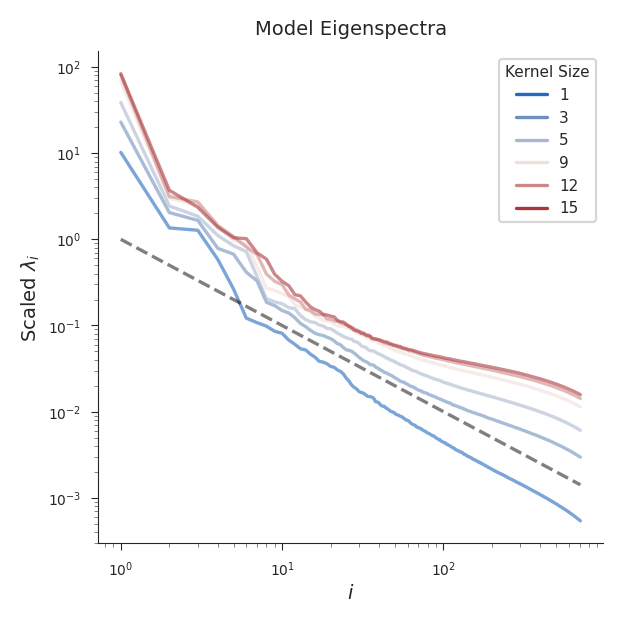

ED p 0.13


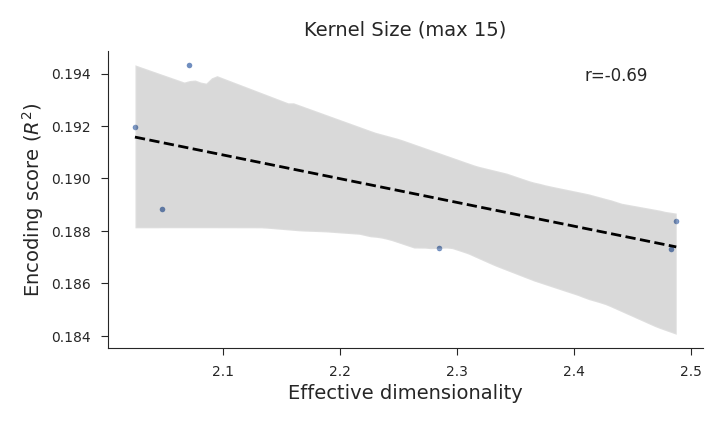

alpha p 0.2613


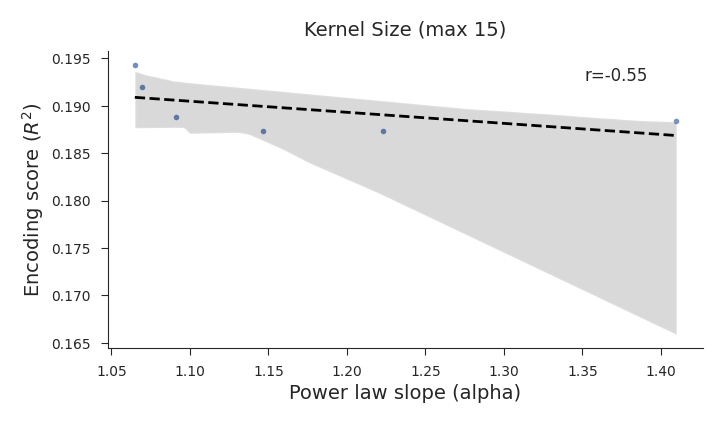

kernel size p 0.0168


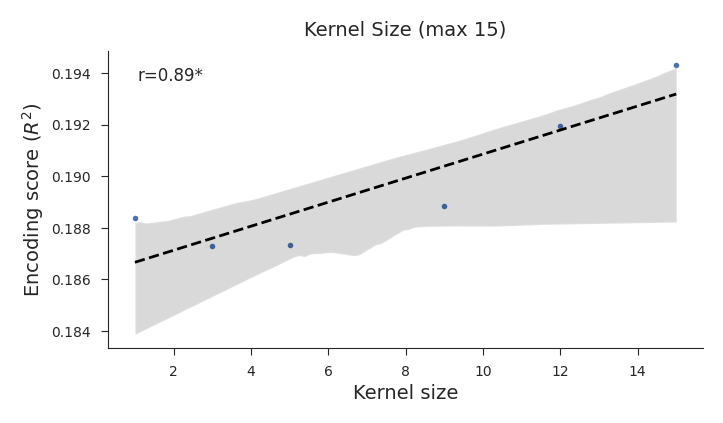

kernel size p 0.0121


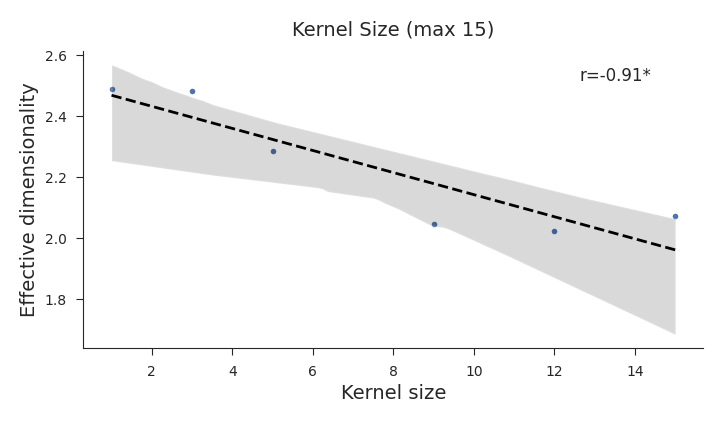

kernel size p 0.0286


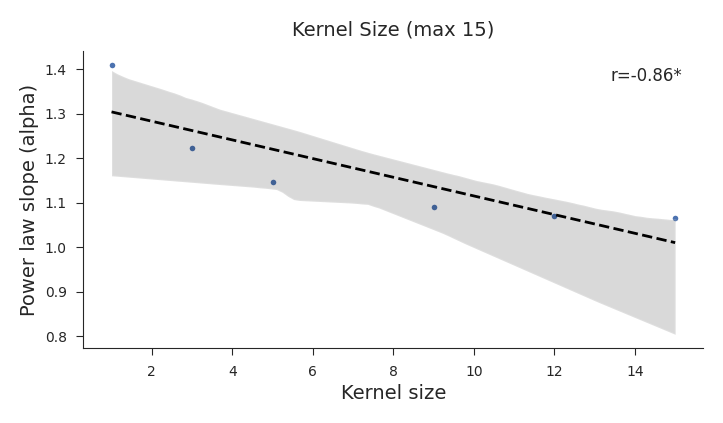

In [73]:
#Kernel Size (1-15) (all has to 31)

metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANksize_use|dataset:imagenet|pooling:max|grayscale:False.csv')
spectra = pd.read_csv(f'../../../results_marcc/capstone/eigspectra_ANksize_use|dataset:imagenet|pooling:max|grayscale:False.csv')
data = pd.merge(metrics, spectra, on=id_columns)
data['id'] = data[id_columns].sum(axis='columns')
kernel_size = data['kind'].str.split(pat='_').str[1].astype(int)
data['kernel_size'] = kernel_size
data = data[(data['kernel_size'] != 22)]

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = round(np.log10(data['effective dimensionality']), 2)
kernel_size = data['kind'].str.split(pat='_').str[1].astype(int)
#print(kernel_size)
data['kernel_size'] = kernel_size

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='kernel_size', legend='full',
             units='id', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Model Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Kernel Size')
plt.show()


#_Enoding score_

encoding = pd.read_csv(f'../../../results_marcc/capstone/encoding_ANksize_use|seed:0|pooling:layerPCA|nPCs:1000|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
metrics.loc[:, 'source'] = metrics['source'].replace({'pcs_NA': 'pcs_1000'})
data = pd.merge(encoding, metrics, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

kernel_size = data['kind'].str.split(pat='_').str[1].astype(int)
data['kernel_size'] = kernel_size
data = data[(data['kernel_size'] != 22)]

#___no logs___

r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])
print('ED p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title='Kernel Size (max 15)')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0, 10)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#alpha

#___no logs___
r, p = sp.stats.pearsonr(data['alpha'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Power law slope (alpha)', ylabel=r'Encoding score ($R^2$)', title='Kernel Size (max 15)')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()



#_Kernel size & Score_
r, p = sp.stats.pearsonr(data['kernel_size'], data['score'])
print('kernel size p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='kernel_size', y='score', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Kernel size', ylabel=r'Encoding score ($R^2$)', title='Kernel Size (max 15)')#, xscale='log')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#_Kernel size & ED_
r, p = sp.stats.pearsonr(data['kernel_size'], data['effective dimensionality'])
print('kernel size p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='kernel_size', y='effective dimensionality', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Kernel size', ylabel=r'Effective dimensionality', title='Kernel Size (max 15)')#, xscale='log')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()



#_Kernel size & alpha_
r, p = sp.stats.pearsonr(data['kernel_size'], data['alpha'])
print('kernel size p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='kernel_size', y='alpha', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Kernel size', ylabel=r'Power law slope (alpha)', title='Kernel Size (max 15)')#, xscale='log')
ax.text(.85, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


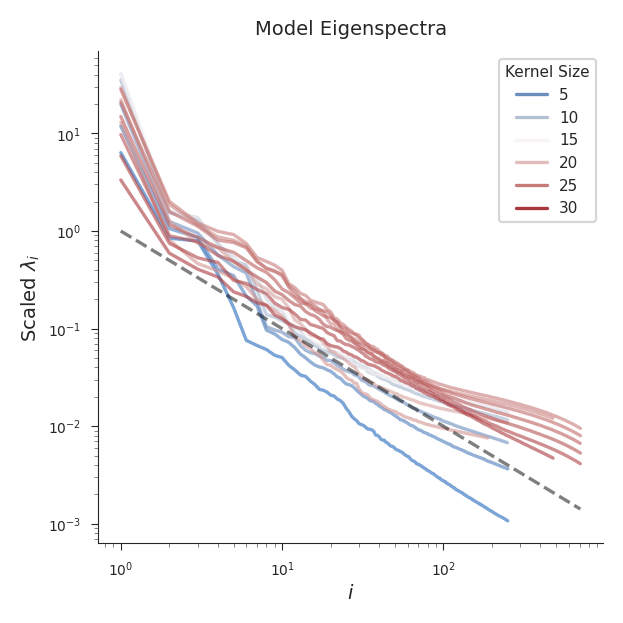

ED p 0.0021


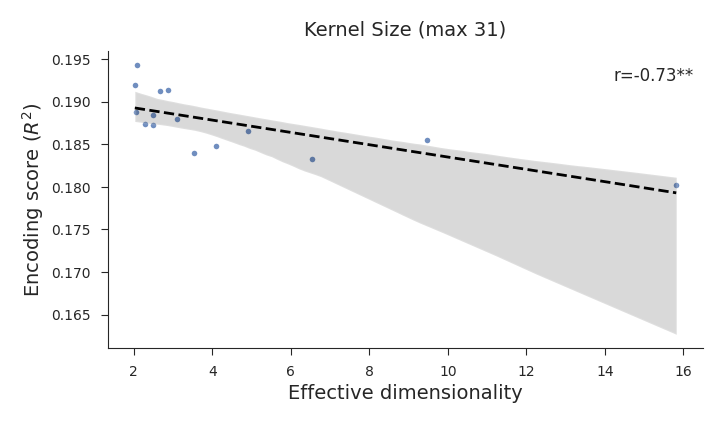

alpha p 0.2821


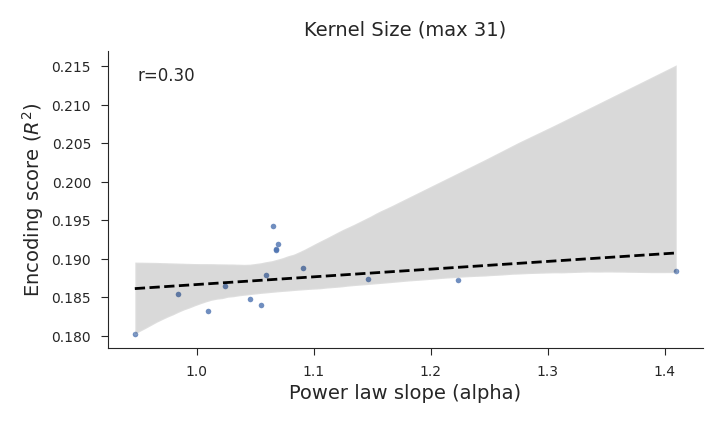

kernel size p 0.0882


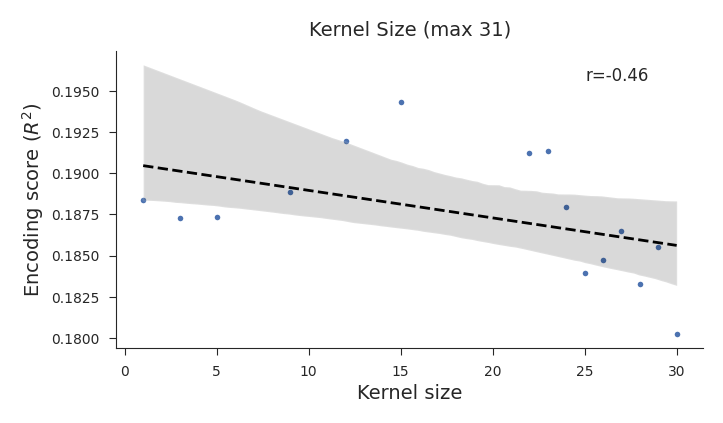

kernel size p 0.0185


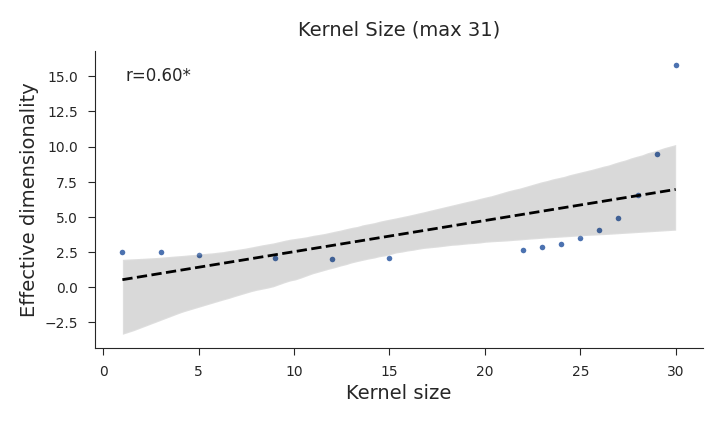

kernel size p 0.0001


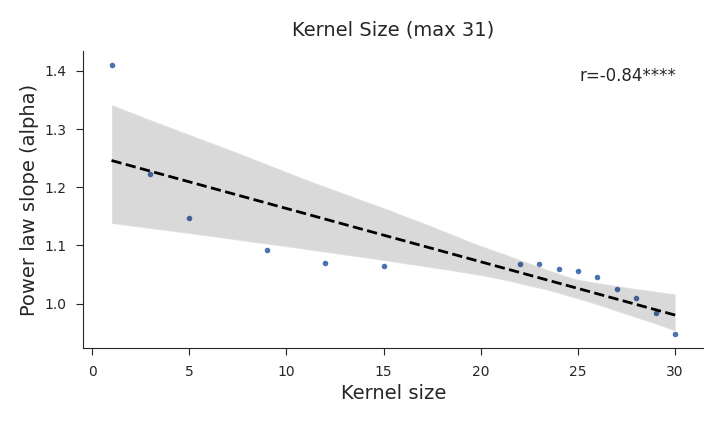

In [72]:
#Kernel Size (all):

metrics = pd.read_csv(f'../../../results_marcc/capstone/eigmetrics_ANksize_all|dataset:imagenet|pooling:max|grayscale:False.csv')
spectra = pd.read_csv(f'../../../results_marcc/capstone/eigspectra_ANksize_all|dataset:imagenet|pooling:max|grayscale:False.csv')
data = pd.merge(metrics, spectra, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
data.drop(data[ data['kind'] == 'ksize_31'].index, inplace=True)

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = round(np.log10(data['effective dimensionality']), 2)
kernel_size = data['kind'].str.split(pat='_').str[1].astype(int)
#print(kernel_size)
data['kernel_size'] = kernel_size

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='kernel_size', legend='auto',
             units='id', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Model Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Kernel Size')
plt.show()


#_Enoding score_

encoding = pd.read_csv(f'../../../results_marcc/capstone/encoding_ANksize_all|seed:0|pooling:layerPCA|nPCs:1000|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
metrics.loc[:, 'source'] = metrics['source'].replace({'pcs_NA': 'pcs_1000'})
data = pd.merge(encoding, metrics, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data.drop(data[ data['kind'] == 'ksize_31'].index, inplace=True)

#___no logs___
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])
print('ED p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', title='Kernel Size (max 31)')
ax.text(.85, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0, 10)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#alpha

#___no logs___
r, p = sp.stats.pearsonr(data['alpha'], data['score'])
print('alpha p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''
    
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='alpha', y='score', 
            logx=False,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Power law slope (alpha)', ylabel=r'Encoding score ($R^2$)', title='Kernel Size (max 31)')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.4, 3.3)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()


#_Kernel size & Score_
kernel_size = data['kind'].str.split(pat='_').str[1].astype(int)
data['kernel_size'] = kernel_size

r, p = sp.stats.pearsonr(data['kernel_size'], data['score'])
print('kernel size p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='kernel_size', y='score', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Kernel size', ylabel=r'Encoding score ($R^2$)', title='Kernel Size (max 31)')#, xscale='log')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()

#_Kernel size & ED_
r, p = sp.stats.pearsonr(data['kernel_size'], data['effective dimensionality'])
print('kernel size p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='kernel_size', y='effective dimensionality', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Kernel size', ylabel=r'Effective dimensionality', title='Kernel Size (max 31)')#, xscale='log')
ax.text(.05, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()

#_Kernel size & alpha_
r, p = sp.stats.pearsonr(data['kernel_size'], data['alpha'])
print('kernel size p', round(p, 4))
if p < 0.0001:
    sig = '****'
elif p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = ''

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
sns.regplot(data=data, x='kernel_size', y='alpha', 
            logx=False,
            scatter_kws={'alpha': 1, 's': 4, 'linewidth': 0,},
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Kernel size', ylabel=r'Power law slope (alpha)', title='Kernel Size (max 31)')#, xscale='log')
ax.text(.8, .9, 'r={:.2f}{}'.format(r, sig), transform=ax.transAxes)
#ax.set_xlim(0.8, 270)
#ax.set_ylim(bottom=0, top=0.65)
plt.show()

/data/shared/brainio/brain-score/dicarlo.hvm-public/_014_rx+19.027_ry+19.001_rz-06.152_tx+00.012_ty+00.257_s+00.905_db3cbafc9be2ec451702dbe598390bf19936c09c_256x256.png


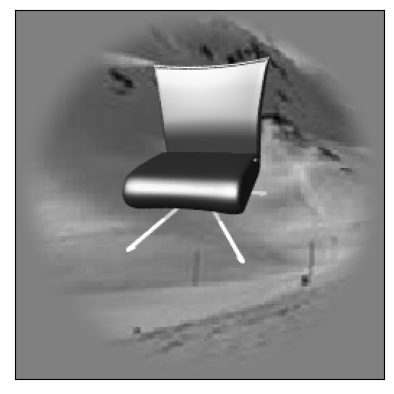

In [30]:
import os
import pandas as pd
import numpy as np
import xarray as xr
from PIL import Image
from matplotlib import pyplot as plt

def paths_from_dir(dir_path):
    image_paths = [os.path.join(dir_path, file) for file in os.listdir(dir_path)]
    return image_paths

def paths_from_csv(image_dir, csv_path, column):
    file_names = pd.read_csv(csv_path)[column].values.tolist()
    image_paths = [os.path.join(image_dir, file) for file in file_names]
    return image_paths

def images_from_dir(dir_path, return_da=False):
    images = np.stack([Image(i) for i in os.listdir(dir_path)])
    if return_da:
        images = xr.DataArray(data=images)
    return images

def images_from_path(image_paths, return_da=False):
    images = np.stack(Image.open(i) for i in image_paths)
    if return_da:
        images = xr.DataArray(data=images)
    return images

def load_single_image(image_paths, index):
    i = image_paths[index]
    print(i)
    image = np.asarray(Image.open(i))
    return image

imagenet = False
if imagenet:
    imagenet_dir = '/data/shared/.cache/brainscore/model-tools/imagenet2012.hdf5-files'
    imagenet_paths = paths_from_dir(imagenet_dir)
    imagenet_image = load_single_image(imagenet_paths, index=12040)
     # - index up to 12040-1
    #imagenet_images = images_from_dir(imagenet_dir)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagenet_image)
    plt.show()
    #for rockfish check MT_HOME path (actually for any project)
    #'/data/keaton/model-tools/imagenet2012.hdf5-files'

majaj_hong = False
if majaj_hong:
    majaj_dir = '/data/shared/brainio/brain-score/dicarlo.hvm-public'
    majaj_csv = '/data/shared/brainio/brain-score/image_dicarlo_hvm-public.csv'
    majaj_column = 'image_file_name'
    majaj_paths = paths_from_csv(majaj_dir, majaj_csv, column=majaj_column)
    majaj_image = load_single_image(majaj_paths, index=1420)
    # - index up to 3200-1
    #on rockfish cannnot use images_from_dir for mjh images (csv file is in the directory), on server can use images_from_dir
    plt.xticks([])
    plt.yticks([])
    plt.imshow(majaj_image)
    plt.show()
    #rockfish = '/home/wtownle1/data-mbonner5/shared/brainio/bonner-datasets/image_dicarlo_hvm-public'
    #rockfish csv: '/home/wtownle1/data-mbonner5/shared/brainio/bonner-datasets/image_dicarlo_hvm-public/image_dicarlo_hvm-public.csv'

ilsvrc = True
if ilsvrc:
    train = True
    test = True
    #ilsvrc_val contains directories (ex: n03188531), didn't find a csv to parse them
    ilsvrc_root = '/data/shared/datasets/ilsvrc2012'
    ilsvrc_csv = '/data/shared/datasets/ilsvrc2012/ilsvrc2012.csv'
    # - csv links to only train images
    ilsvrc_test_dir = os.path.join(ilsvrc_root, 'test')
    if train:
        ilsvrc_train_paths = paths_from_csv(ilsvrc_root, ilsvrc_csv, column='filename')
        ilsvrc_train_image = load_single_image(ilsvrc_train_paths, index=0)
    if test:
        ilsvrc_test_paths = paths_from_dir(ilsvrc_test_dir)
        ilsvrc_test_image = load_single_image(ilsvrc_test_paths)